# Telecom Customer Churn Prediction

# Contents <a id='back'></a>

* [1. Introduction](#intro)
    * [1.1 Project Description](#description)
    * [1.2 Problems](#problems)
    * [1.3 Objectives](#objectives)
* [2. Methodology](#method)
* [3. Initialisation](#init)
* [4. Data Exploration](#data_exploration)
    * [4.1 Conclusion](#exploration_conclusion)
* [5. Data Preprocessing](#data_preprocessing)
    * [5.1 Merging the Datasets](#merge)
    * [5.2 Solving Identified Issues in Data Exploration](#solve_issues)
    * [5.3 Feature Engineering](#feature)
* [6. Exploratory Data Analysis (EDA)](#eda)
    * [6.1 Monthly Payment Distributions for Active Customers and Customers who Have Left](#monthly_payment)
    * [6.2 Customer Share Per Service Type](#service_type)
    * [6.3 Customer Inflow and Outflow](#flows)
    * [6.4 Distribution of Key Variables Per Service Type](#key_variables)
    * [6.5 Churn Rate Per Categorical Feature](#categorical_features)
    * [6.6 Correlation Coefficients of Numerical Features and Target](#correlation)
    * [6.7 Distributions of Numercical Features Per Target Class](#numerical_features)
    * [6.8 Distribution of Target Classes](#target_classes)
    * [6.9 Conclusion](#eda_conclusion)
* [7. Modeling](#modeling)
    * [7.1 Model Training](#train_model)
        * [7.1.1 Constant Model](#constant)
        * [7.1.2 Logistic Regression](#lr)
        * [7.1.3 Decision Tree](#dt)
        * [7.1.4 LightGBM](#lgbm)
        * [7.1.5 CatBoost](#cat)
        * [7.1.6 XGBoost](#xgb)
* [8. Model Evaluation](#model_evaluation)
    * [8.1 Final Model Selection](#final_model)
    * [8.2 Feature Importances](#feature_importances)
    * [8.3 Evaluation of the Final Model on the Test Set](#test_evaluation)
* [9. General Conclusion](#general_conclusion)
* [10. Model Deployment](#deployment)
* [11. Recommendations](#recommendations)

## 1. Introduction <a id='intro'></a>

### 1.1 Project Description <a id='description'></a>

The telecom opertor *Interconnect* would like to identify potential leaving customers. If they discover a customer is planning to leave, they will offer the customer promotional codes and special plan options. The Interconnect's marketing team has collected some of their clientele's personal data, including the information about the clientele's plan and contract.

Interconnect mainly provides two types of services:

1. Landline communication: The telephone can be connected to several lines simultaneously.
2. Internet: The network can be set up via telephone line (DSL, *digital subscriber line*) or through a fiber optic cable. Some optional services for internet users are listed as follows.
    - Antivirus software (*Device Protection*)
    - Malicious website blocker (*Online Security*)
    - Dedicated technical support line (*Tech Support*)
    - Cloud file storage and data backup (*Online Backup*)
    - TV streaming (*Streaming TV*)
    - Movie directory (*Streaming Movies*)

The clients can choose either a monthly payment or sign a one- or two-year contract.

### 1.2 Problems <a id='problems'></a>

This project aims to solve the following problems.

- What are some common traits or patterns among those who have left?
- How accurate can customer churn predicted with a machine learning model?

### 1.3 Objectives <a id='objectives'></a>

To solve the problems mentioned above, the objectives of this project are

1. To identify the characteristics and behaviours that distinguish between active customers and those who are likely to leave.
2. To develop a machine learning model to predict customer churn with a AUC-ROC score of at least 0.85.

[Back to Contents](#back)

## 2. Methodology <a id='method'></a>

The customer characteristics and behaviours will be analysed and assessed to identify factors contributing to customer churn. The prediction of a leaving customer is a supervised machine learning task, therefore various classification models will be developed.

## 3. Initialisation <a id='init'></a>

In [1]:
# Data manipulation and preprocessing
import pandas as pd
import numpy as np
from functools import reduce
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import time
from tqdm.auto import tqdm

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Classification Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Model selection and evalution
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import optuna

# Model saving
import os
import pickle

# Suppress warning messages
import warnings
warnings.filterwarnings('ignore')

# Produce graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

[Back to Contents](#back)

## 4. Data Exploration <a id='data_exploration'></a>

The marketing team of telecom operator Interconnect has provided us four datasets which include

- `contract.csv` - contract information
- `personal.csv` - the client's personal data
- `internet.csv` - information about internet services
- `phone.csv` - information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

As mentioned by the marketing team, the contract information is valid as of *February 1, 2020*.

Now, let's load the datasets and have some investigations.

In [2]:
# Load the four datasets
try:
    df_contract = pd.read_csv('contract.csv')
    df_personal = pd.read_csv('personal.csv')
    df_internet = pd.read_csv('internet.csv')
    df_phone = pd.read_csv('phone.csv')
except:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

print('All datasets have been successfully loaded.')

All datasets have been successfully loaded.


**`contract`**

In [3]:
# Have a look at the first five rows
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
# Check the shape
df_contract.shape

(7043, 8)

In the `contract` dataset, there are 7043 rows (customers) and 8 columns information related to each customer's contract.

**Description of data**

- `customerID`: A unique identifier for the customer.
- `BeginDate`: The date when the customer started using the service(s).
- `EndDate`: The date when the customer terminated the service. A value of `No` indicates that the customer is still using the service(s) at the time when the data is extracted (February 1, 2020).
- `Type`: The contract type (e.g. Month-to-month, One year, etc.).
- `PaperlessBilling`: A binary value which indicates whether the customer has opted for paperless billing.
- `PaymentMethod`: The method to make payments for the subsribed service(s) (e.g. Electronic check, Mailed check, etc.).
- `MonthlyCharges`: The amount charged to the customer on a monthly basis.
- `TotalCharges`: The accumulated amount charged to the customer over the entire subcription duration.

**Issues and Solutions**

- The column names are in camal case, we will convert them into snake case.
- The `EndDate` column has the values `No` which are not date values. These values will be replaced with `None` and an additional column `churn` will be created to indicate if a customer has left.

In [5]:
# Check for duplicates
df_contract.duplicated().sum()

0

In [6]:
# Check for missing values
df_contract.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [7]:
# Check the data types
df_contract.dtypes

customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object

The dataset has no duplicate or missing value.

**Issues and Solutions**

-  The data types for the `BeginDate` and `EndDate` are incorrect and will be converted into `datetime`.
-  The `TotalCharges` column should have a `float` data type. This shows that there are some non-numeric values in the column. We will find out these non-numeric values and replaced them accordingly so that we can convert the data type into `float`.

In [8]:
# Check the statistical summary
df_contract.describe(include='all')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,5,3,2,4,NaN,6531
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


No obvious outlier or anomaly, except the `TotalCharges` column. Let's have a check on the 11 non-numeric values in the `TotalCharges` column.

In [9]:
# Have a check on the 11 rows with non-date value in TotalCharges
df_contract.query('TotalCharges == " "')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


It can be seen that all of these 11 rows have a `BeginDate` of `2020-02-01` and an `EndDate` of `No`. This infers that these customer are newly acquired customers and have not make any payment yet. Thus, they will be replaced with `0`.

We have gained some basic understanding of the `contract` dataset. Next, we shall proceed to the `personal` dataset.

**`personal`**

In [10]:
# Look at the first five rows
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [11]:
# Check the shape
df_personal.shape

(7043, 5)

In the `personal` dataset, there are 7043 rows (customers) and 5 columns information related to each customer. The numeber of rows of `7043` matches the total row number in the `contract` dataset.

**Description of data**

- `customerID`: A unique identifier for the customer.
- `gender`: The gender of the customer (e.g. Female, Male)
- `SeniorCitizen`: A binary value to indicate whether the customer is a senior citizen.
- `Partner`: A binary value to indicate whether the customer has a partner.
- `Dependents`: A binary value to indicate whether the customer has dependents, such as children or other individuals who rely on them financially.

**Issue and Solution**

- Similary, we will convert the column names into snake case.

In [12]:
# Check for dupliates
df_personal.duplicated().sum()

0

In [13]:
# Check for missing values
df_personal.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [14]:
# Check the data types
df_personal.dtypes

customerID       object
gender           object
SeniorCitizen     int64
Partner          object
Dependents       object
dtype: object

There is no duplicate or missing value. The data types are also correct.

In [15]:
# Check the statistical summary
df_personal.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


No obvious anomaly or outlier is found.

Let's move to the `internet` dataset.

**`internet`**

In [16]:
# Check the first five rows
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [17]:
# Check the shape
df_internet.shape

(5517, 8)

There are 5517 customers who have used or is using the internet service.

**Description of data**

- `customerID` - A unique identifier for the customer.
- `InternetService` The type of internet service subsribed by the customer (e.g. DSL, Fiber optic)
- `OnlineSecurity`: A binary value which indicates if the customer has online security feature for the internet connection.
- `OnlineBackup`: A binary value which indicates if the customer has online backup service for the data.
- `DeviceProtection`: A binary value which indicates if the customer has device protection service for the connected device.
- `TechSupport`: A binary value which indicates if the customer has access to the technical support service.
- `StreamingTV`: A binary value which indicates if the customer has subscribed for the streaming TV service.
- `StreamingMovies`: A binary value which indicates if the customer has subscribed for the streaming movie service.

**Issue and Solution**

- The column names will be converted into snake case.

In [18]:
# Check for duplicates
df_internet.duplicated().sum()

0

In [19]:
# Check for missing values
df_internet.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [20]:
# Check the data types
df_internet.dtypes

customerID          object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
dtype: object

No missing value or duplicate and the data types are all correct.

In [21]:
# Have a look at the statistical summary
df_internet.describe(include='all')

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


No obvious anomaly is detected.

Let's proceed with the final dataset.

**`phone`**

In [22]:
# Have a look at the first five rows
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [23]:
# Check the shape
df_phone.shape

(6361, 2)

There are 6361 customers who have used or is using the landline communication service.

**Description of data**

- `customerID`: A unique identifier for the customer.
- `MultipleLines`: A binary value which indicates whether the customer has subcribed for the multiple lines.

**Issue and Solution**

- The column names will be converted into snake case.

In [24]:
# Check for duplicates
df_phone.duplicated().sum()

0

In [25]:
# Check for missing values
df_phone.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

In [26]:
# Check the data types
df_phone.dtypes

customerID       object
MultipleLines    object
dtype: object

There is no duplicate or missing value and all the data types are correct.

In [27]:
# Look at the statistical summary
df_phone.describe(include='all')

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


No anomaly is found.

### 4.1 Conclusion <a id='exploration_conclusion'></a>

1. The four datasets consist of information of 7043 customers. The information related to the contract, personal details and the service types they have subscribed for.
2. There are serveral issues have been identified as follows.
    - All the column names are in camal case, they will be converted into snake case.
    - The `EndDate` has some values of `No` which are not date values. These values will be replaced with `None` and an additional column `churn` will be created to indicate if a customer has left.
    - The `TotalCharges` column has non-numeric values which indicate that the customers are new clients. Therefore, these values will be replaced with `0`.
    - The data types of `BeginDate`, `EndDate` and `TotalCharges` are incorrect and will be adjusted accordingly.
  
[Back to Contents](#back)

## 5. Data Preprocessing <a id='data_preprocessing'></a>

### 5.1 Merging the Datasets <a id='merge'></a>

First of all, the four datasets will be merged into one based on the common column `customerID`.

In [28]:
# Merge the four datasets
df_all = reduce(lambda left, right: left.merge(right, on='customerID', how='left'),
                [df_contract, df_personal, df_internet, df_phone])

In [29]:
# Have a look at the merged dataset
df_all.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [30]:
# Check if the row number is 7043
df_all.shape

(7043, 20)

In [31]:
# Check the missing values
df_all.isna().sum().nlargest(10)

InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
customerID             0
BeginDate              0
dtype: int64

These missing values are due to the fact that not all clients have subscribed for both the `internet` and `phone` services. Therefore, we will fill these missing values with `not_subscribed`.

In [32]:
# Get the columns with missing values
na_columns = [col for col in df_all.columns if df_all[col].isna().sum() > 0]

In [33]:
# Fill the missing values with `not_subscribed`.
df_all[na_columns] = df_all[na_columns].fillna('not_subscribed')

# Check the unqiue values in these columns
for col in na_columns:
    display(df_all[col].value_counts())
    print()

InternetService
Fiber optic       3096
DSL               2421
not_subscribed    1526
Name: count, dtype: int64

OnlineSecurity
No                3498
Yes               2019
not_subscribed    1526
Name: count, dtype: int64

OnlineBackup
No                3088
Yes               2429
not_subscribed    1526
Name: count, dtype: int64

DeviceProtection
No                3095
Yes               2422
not_subscribed    1526
Name: count, dtype: int64

TechSupport
No                3473
Yes               2044
not_subscribed    1526
Name: count, dtype: int64

StreamingTV
No                2810
Yes               2707
not_subscribed    1526
Name: count, dtype: int64

StreamingMovies
No                2785
Yes               2732
not_subscribed    1526
Name: count, dtype: int64

MultipleLines
No                3390
Yes               2971
not_subscribed     682
Name: count, dtype: int64

The datasets have been merged sucessfully. Next, we will deal with the issues mentioned in the previous stage.

[Back to Contents](#back)

### 5.2 Solving Identified Issues in Data Exploration <a id='solve_issues'></a>

**Convert the Column Names into Snake Case**

In [34]:
# Convert the column name into snake case
df_all.columns = [re.sub(r'([A-Z])', r' \1', col).lower().strip().replace(' ', '_') for col in df_all.columns]

In [35]:
# Check the column names
df_all.columns

Index(['customer_i_d', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_t_v', 'streaming_movies', 'multiple_lines'],
      dtype='object')

The column names are now in snake case but we have to make some corrections for the `customer_i_d` and `streaming_t_v` columns.

In [36]:
# Correct the correct names of customer_id and streaming_tv
df_all.rename(columns={
    'customer_i_d': 'customer_id',
    'streaming_t_v': 'streaming_tv'
}, inplace=True)

# Final check the column names
df_all.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

**Create the Target Variable**

To predict whether a customer will leave, we need a target variable. An additional column `churn` will be created by using the `end_date` column. The `No` values indicate the customers are still active while the other date values indicate the service terminated date for those who have left.

In [37]:
# Create the target `churn` by using the `end_date` column
df_all['churn'] = df_all['end_date'].map(lambda date: 0 if date == 'No' else 1)

# Check if the column is correctly created
df_all[['end_date', 'churn']].head()

,end_date,churn
0,No,0
1,No,0
2,2019-12-01 00:00:00,1
3,No,0
4,2019-11-01 00:00:00,1


**Convert the Data Types**

We have to replace the `No` in `end_date` with `None` and ` ` in `total_charges` with `0` before the conversion.

In [38]:
# Replace the `No` in `end_date` with None
df_all['end_date'].replace('No', np.nan, inplace=True)

# Check if the replacement has been made
df_all['end_date'].head()

0                    NaN
1                    NaN
2    2019-12-01 00:00:00
3                    NaN
4    2019-11-01 00:00:00
Name: end_date, dtype: object

In [39]:
# Replace the blank value in `total_charges` with `0`
df_all['total_charges'].replace(' ', 0, inplace=True)

# Check if there are 11 rows with `0` in `total_charges`
len(df_all.query('total_charges == 0'))

11

In [40]:
# Convert the data types
df_all['begin_date'] = pd.to_datetime(df_all['begin_date'], format='%Y-%m-%d')
df_all['end_date'] = pd.to_datetime(df_all['end_date'], format='%Y-%m-%d %H:%M:%S')
df_all['total_charges'] = df_all['total_charges'].astype(float)

In [41]:
# Final check the data types
df_all.dtypes

customer_id                  object
begin_date           datetime64[ns]
end_date             datetime64[ns]
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges               float64
gender                       object
senior_citizen                int64
partner                      object
dependents                   object
internet_service             object
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
multiple_lines               object
churn                         int64
dtype: object

The data types are all correct.

It is suspected that the `monthly_charges` for February 2020 has not been added to the `total_charges` since the 11 new customers do not have any payment record in the `total_charges`. If this is the case, we will add the `monthly_charges` to the `total_charges` for the active customers.

In [42]:
# Check the first record in the dataset
df_all.loc[0, ['begin_date', 'end_date', 'monthly_charges', 'total_charges']]

begin_date         2020-01-01 00:00:00
end_date                           NaT
monthly_charges                  29.85
total_charges                    29.85
Name: 0, dtype: object

The customer should be charged for two months but the `total_charges` only reflects one month of billing, this verifies the speculation.

In [43]:
# Before adding 'monthly_charges'
df_all[['churn', 'monthly_charges', 'total_charges']].head()

,churn,monthly_charges,total_charges
0,0,29.85,29.85
1,0,56.95,1889.50
2,1,53.85,108.15
3,0,42.30,1840.75
4,1,70.70,151.65


In [44]:
# Add `monthly_charges` to the existing customers
df_all['total_charges'] = (df_all['total_charges'] + df_all['monthly_charges']) \
                          .where(df_all['churn'] == 0, df_all['total_charges'])

In [45]:
# Have a check after the addition
df_all[['churn', 'monthly_charges', 'total_charges']].head()

,churn,monthly_charges,total_charges
0,0,29.85,59.70
1,0,56.95,1946.45
2,1,53.85,108.15
3,0,42.30,1883.05
4,1,70.70,151.65


[Back to Contents](#back)

### 5.3 Feature Engineering <a id='feature'></a>

In this section, some additional features will be created from the exsiting features to enhance the model performance. The relationship between the additional features and customer churn will be examined in the EDA stage.

**`subscribed_days`** and **`subscribed_years`**

Ususlly, the longer the subscription duration, the greater the customer loyalty. Therefore, these features might help to predict customer churn.

To find the total days of subscription for the
- Custormers who have left: Subtract `begin_date` from `end_date` and extract the `day` value.
- Active customers: Subtract `begin_date` from `2020-02-01` and extract the `day` value.

To find the total years of subscription for the
- Custormers who have left: Subtract the year of `begin_date` from the year of `end_date`.
- Active customers: Subtract the year of `begin_date` from the year 2020.

In [46]:
# Create the datetime value when the data was extracted
extract_date = pd.to_datetime('2020-02-01', format='%Y-%m-%d')

# Calculate the total days of subscription
df_all['subscribed_days'] = (df_all['end_date'] - df_all['begin_date']) \
                            .where(df_all['churn'] == 1, extract_date - df_all['begin_date']) \
                            .dt.days

In [47]:
# Calculate the total years of subscription
df_all['subscribed_years'] = (df_all['end_date'].dt.year - df_all['begin_date'].dt.year) \
                             .where(df_all['churn'] == 1, 2020 - df_all['begin_date'].dt.year)

In [48]:
# Have a check on the subscribed_days and subcribed_years columns
df_all[['churn', 'begin_date', 'end_date', 'subscribed_days', 'subscribed_years']].head()

,churn,begin_date,end_date,subscribed_days,subscribed_years
0,0,2020-01-01,NaT,31,0.0
1,0,2017-04-01,NaT,1036,3.0
2,1,2019-10-01,2019-12-01,61,0.0
3,0,2016-05-01,NaT,1371,4.0
4,1,2019-09-01,2019-11-01,61,0.0


**`subscribed_services`** and **`total_internet_services`**

The more subscribed services, the greater the customer reliance on the telecom operator, making it less likely for them to leave the company.

- `subscribed_service`: Type of subscribed service.
- `total_internet_services`: Total number of services from `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, and `streaming_movies`.

In [49]:
# Define a funtion to calculate `total_services` for each customer
def assign_service_type(row):
    '''
    Assign the type of service subscribed by a customer.
    '''
    if row['internet_service'] != 'not_subscribed' and row['multiple_lines'] == 'not_subscribed':
        return 'internet_service'
    elif row['internet_service'] == 'not_subscribed' and row['multiple_lines'] != 'not_subscribed':
        return 'landline_communication'
    else:
        return 'both'

In [50]:
# Assign the `subscribed_services`
df_all['subscribed_service'] = df_all.apply(assign_service_type, axis=1)

In [51]:
# Have a check on the `subscribed_services` column
df_all[['internet_service', 'multiple_lines', 'subscribed_service']].head()

,internet_service,multiple_lines,subscribed_service
0,DSL,not_subscribed,internet_service
1,DSL,No,both
2,DSL,No,both
3,DSL,not_subscribed,internet_service
4,Fiber optic,No,both


In [52]:
# Create a list of internet services provided by the telecom operator
internet_services = ['online_security', 'online_backup', 'device_protection',
                     'tech_support', 'streaming_tv', 'streaming_movies']

# Define a function to calculate `total_internet_services` for each customer
def calc_total_internet_services(row):
    '''
    Calculate and return total number of subsribed internet services of a customer
    '''
    count = 0

    for service in internet_services:
        if row[service] == 'Yes':
            count += 1

    return count

In [53]:
# Calculate the `total_internet_services`
df_all['total_internet_services'] = df_all.apply(calc_total_internet_services, axis=1)

In [54]:
# Have a check on the `total_internet_services` column
df_all[internet_services + ['total_internet_services']].sample(5)

,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,total_internet_services
1303,not_subscribed,not_subscribed,not_subscribed,not_subscribed,not_subscribed,not_subscribed,0
1304,No,No,No,No,No,Yes,1
3840,not_subscribed,not_subscribed,not_subscribed,not_subscribed,not_subscribed,not_subscribed,0
6929,not_subscribed,not_subscribed,not_subscribed,not_subscribed,not_subscribed,not_subscribed,0
583,not_subscribed,not_subscribed,not_subscribed,not_subscribed,not_subscribed,not_subscribed,0


We have done with the data preprocessing stage, let's start to analyse the data.

[Back to Contents](#back)

## 6. Exploratory Data Analysis (EDA) <a id='eda'></a>

The function below will automate the tasks in this stage.

In [55]:
def plot_filled_bar_chart(data, x, title, legend=True):
    '''
    Plot a filled bar chart to show the distribution of active customers 
    and customer who have left given a feature
    '''
    palette = ['steelblue', 'tomato']
    sns.histplot(data=data, x=x, hue='churn', multiple='fill', discrete=True, 
                 palette=palette, legend=legend, ax=ax)
    ax.set_title(title, fontweight='bold', y=1.0)
    ax.set_xlabel('')    
    ax.set_ylabel('Percentage', fontweight='bold')
    ax.set_yticks(np.linspace(0, 1, 6), np.arange(0, 101, 20))
    
    if legend == True:
        legend_labels = ['active', 'left']
        legend_handles = [Line2D([0], [0], color=palette[0], lw=3),
                          Line2D([0], [0], color=palette[1], lw=3)]
        ax.legend(legend_handles, legend_labels, loc='upper left', bbox_to_anchor=(1, 1))

---

### 6.1 Monthly Payment Distributions for Active Customers and Customers who Have Left <a id='monthly_payment'></a>

In [56]:
# Calculate the descriptive statistics of monthly payment
stats = pd.concat([
    df_all.query('churn == 0')['monthly_charges'].describe(),
    df_all.query('churn == 1')['monthly_charges'].describe()
], axis=1).round(2)

stats.columns = ['active', 'left']

stats

,active,left
count,5174.00,1869.00
mean,61.27,74.44
std,31.09,24.67
min,18.25,18.85
25%,25.10,56.15
50%,64.43,79.65
75%,88.40,94.20
max,118.75,118.35


From the descriptive statistics, it can be concluded that 

- The customers who have left have a higher mean monthly payment of 74.44, compared to the mean monthly payment of active customers, which is 61.27.
- Both groups have almost identical minimum and maximum monthly payment. However, the 25th, 50th and 75th percentiles of customers who have left are significantly higher that those of active customers.

The above result implies that the monthly payment distribution of customers who have left are more left-skewed than that of active customers, i.e. the active customers have lower monthly payments. Let's plot some charts to visualise it.

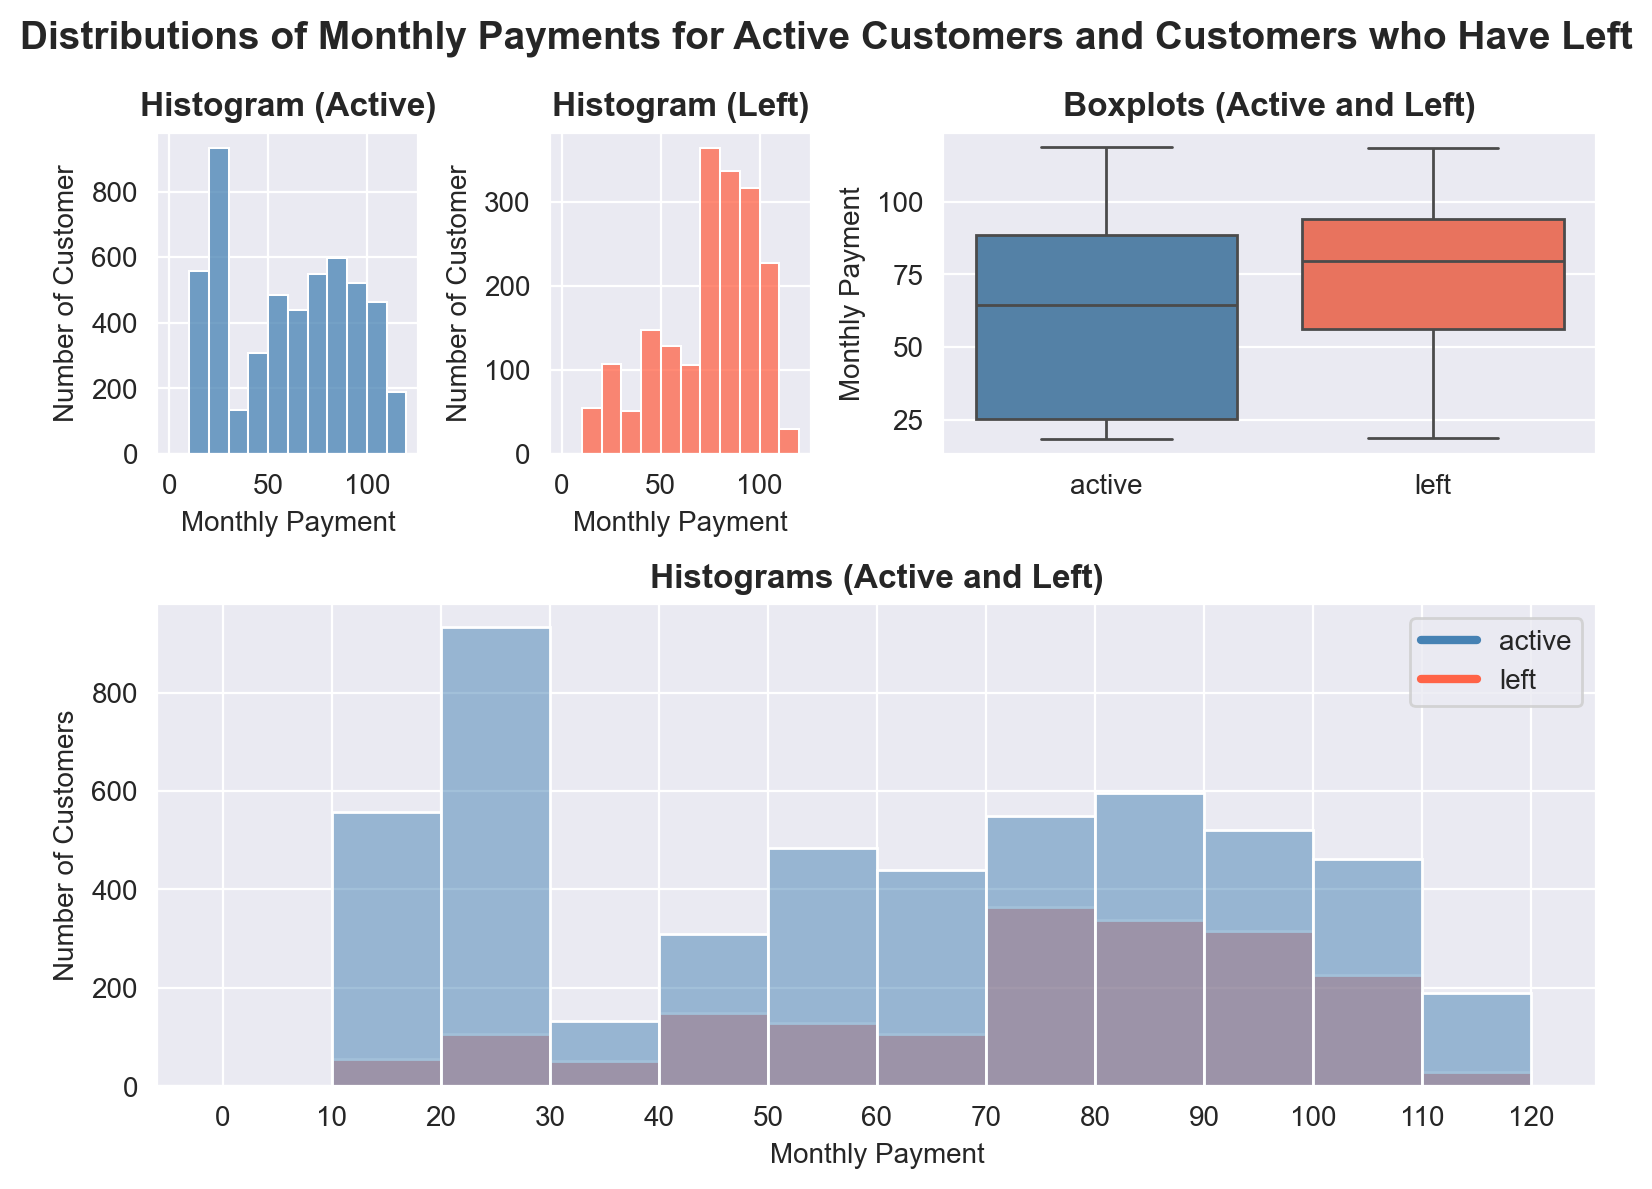

In [57]:
# Plot histograms and boxplots to visualise the distributions
sns.set_style('darkgrid')

layout = '''
    abcc
    dddd
'''

fig, axd = plt.subplot_mosaic(layout, height_ratios=[1.0, 1.5], figsize=(8, 6))

fig.suptitle('Distributions of Monthly Payments for Active Customers and Customers who Have Left',
             fontsize=14, fontweight='bold')

# Plot the histogram for each group
ax = axd['a']
sns.histplot(data=df_all.query('churn == 0'), x='monthly_charges', color='steelblue', 
             bins=np.arange(0, 121, 10), ax=ax)
ax.set_title('Histogram (Active)', fontweight='bold')
ax.set_xlabel('Monthly Payment')
ax.set_ylabel('Number of Customer')

ax = axd['b']
sns.histplot(data=df_all.query('churn == 1'), x='monthly_charges', color='tomato', 
             bins=np.arange(0, 121, 10), ax=ax)
ax.set_title('Histogram (Left)', fontweight='bold')
ax.set_xlabel('Monthly Payment')
ax.set_ylabel('Number of Customer')

# Plot the boxplots
ax = axd['c']
sns.boxplot(data=df_all, x='churn', y='monthly_charges', hue='churn',
            palette=['steelblue', 'tomato'], legend=None, ax=ax)
ax.set_title('Boxplots (Active and Left)', fontweight='bold')
ax.set_xticks([0, 1], ['active', 'left'])
ax.set_xlabel('')
ax.set_ylabel('Monthly Payment')

# Plot the histograms in the same subplot
ax = axd['d']
sns.histplot(data=df_all, x='monthly_charges', hue='churn', bins=np.arange(0, 121, 10),
             palette=['steelblue', 'tomato'], ax=ax)
legend_labels = ['active', 'left']
legend_handles = [Line2D([0], [0], color='steelblue', lw=3),
                  Line2D([0], [0], color='tomato', lw=3)]
ax.set_title('Histograms (Active and Left)', fontweight='bold')
ax.set_xlabel('Monthly Payment')
ax.set_ylabel('Number of Customers')
ax.set_xticks(np.arange(0, 121, 10), np.arange(0, 121, 10))
ax.legend(legend_handles, legend_labels, loc='upper right')

plt.tight_layout()
plt.show()

From the boxplots, it can be seen that the customers who have left indeed has higher monthly payment than the active customers.

From the histograms, the customers can be divided into four groups based on the monthly payment - `0 to 40`, `40 to 70`, `70 to 110` and `110 and above`. The group with monthly payment of `70 to 110` has the highest churn rate.

In [58]:
# Calculate the churn rate for each group of monthly payment
mc_group = pd.cut(
    df_all['monthly_charges'],
    bins=[0, 40, 70, 110, 120],
    labels=['0-40', '40-70', '70-110', '110 and above']
).to_frame()

mc_group['churn'] = df_all['churn']

pivot = mc_group.pivot_table(
    index='monthly_charges',
    columns='churn',
    aggfunc='size'
)

pivot_perc = (pivot.div(pivot.sum(axis=1), axis=0) * 100).round(2)

pivot_perc

churn,0,1
monthly_charges,,
0-40,88.36,11.64
40-70,76.08,23.92
70-110,63.21,36.79
110 and above,86.98,13.02


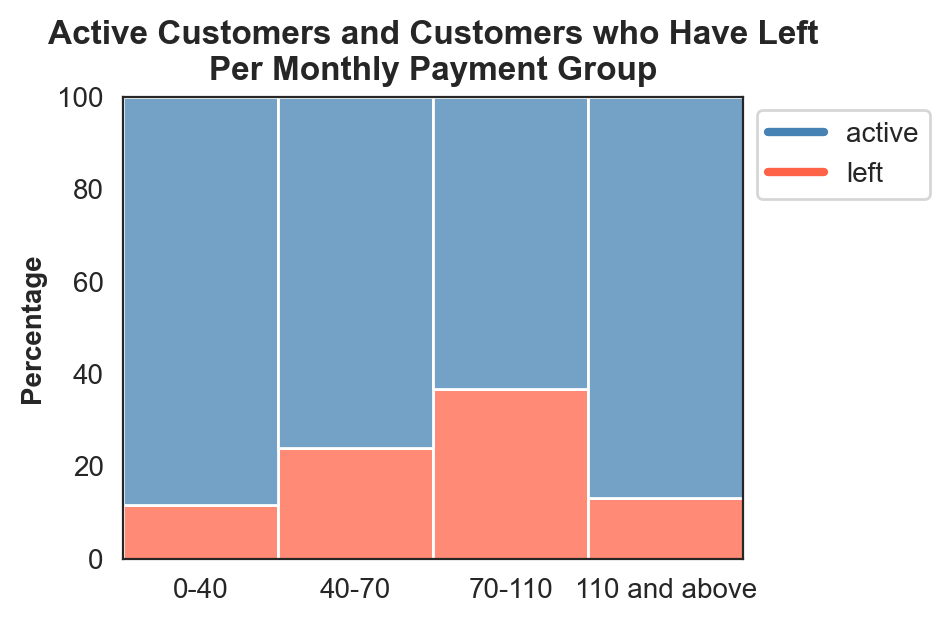

In [59]:
# Plot a filled bar chart
sns.set_style('white')
plt.figure(figsize=(4, 3))

ax = plt.gca()
plot_filled_bar_chart(data=mc_group,
                      x='monthly_charges',
                      title='Active Customers and Customers who Have Left\nPer Monthly Payment Group')

plt.show()

The customers who pay `70-110` per month has the highest churn rate of 36.79%. The marketing department could focus more on this group and develop relevant strategy to retain the customers.

[Back to Contents](#back)

### 6.2 Customer Share Per Service Type <a id='service_type'></a>

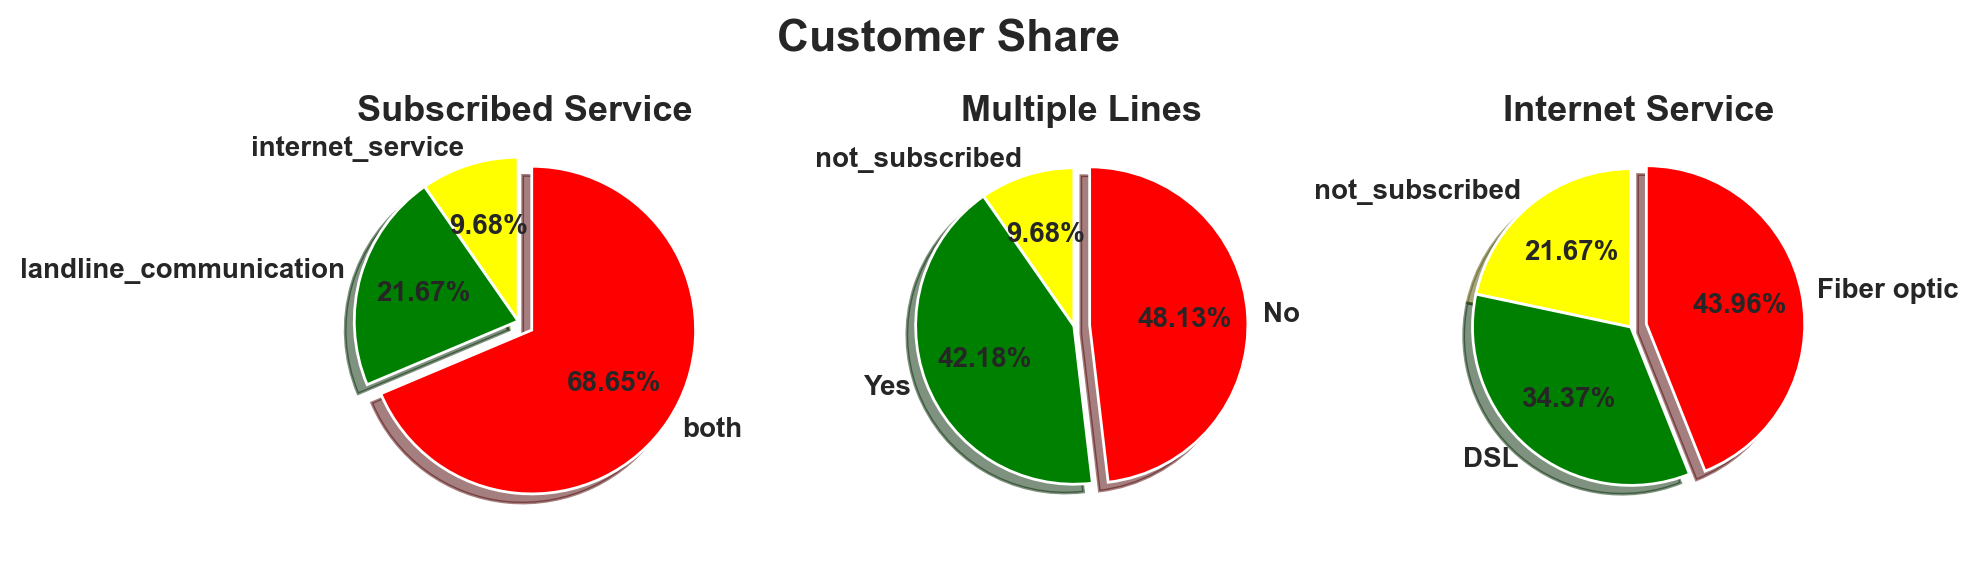

In [60]:
# Plot the pie charts
colors = ['yellow', 'green', 'red']
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

fig.suptitle('Customer Share', x=0.48, y=0.95, fontsize=16, fontweight='bold')

for i, col in enumerate(['subscribed_service', 'multiple_lines', 'internet_service']):
    ax = axs[i]
    df_t = df_all[col].value_counts().sort_values()
    ax.pie(df_t, labels=df_t.index, autopct='%1.2f%%', startangle=90, shadow=True,
           explode=(0, 0, 0.1), colors=colors, textprops={'fontweight': 'bold'})
    ax.axis('equal')
    title = ' '.join([word.capitalize() for word in col.split('_')])
    ax.set_title(title, fontsize=13, fontweight='bold', y=0.9)

plt.tight_layout()
plt.show()

From the pie charts, we can concluded that

- There are 68.65% of the customers subscribed both the services.
- For the landline communication service users, there are more people choose not to use multiple lines but the difference is not significant.
- For the internet service users, the fiber optic is more popular than the DSL.

[Back to Contents](#back)

### 6.3 Customer Inflow and Outflow <a id='flows'></a>

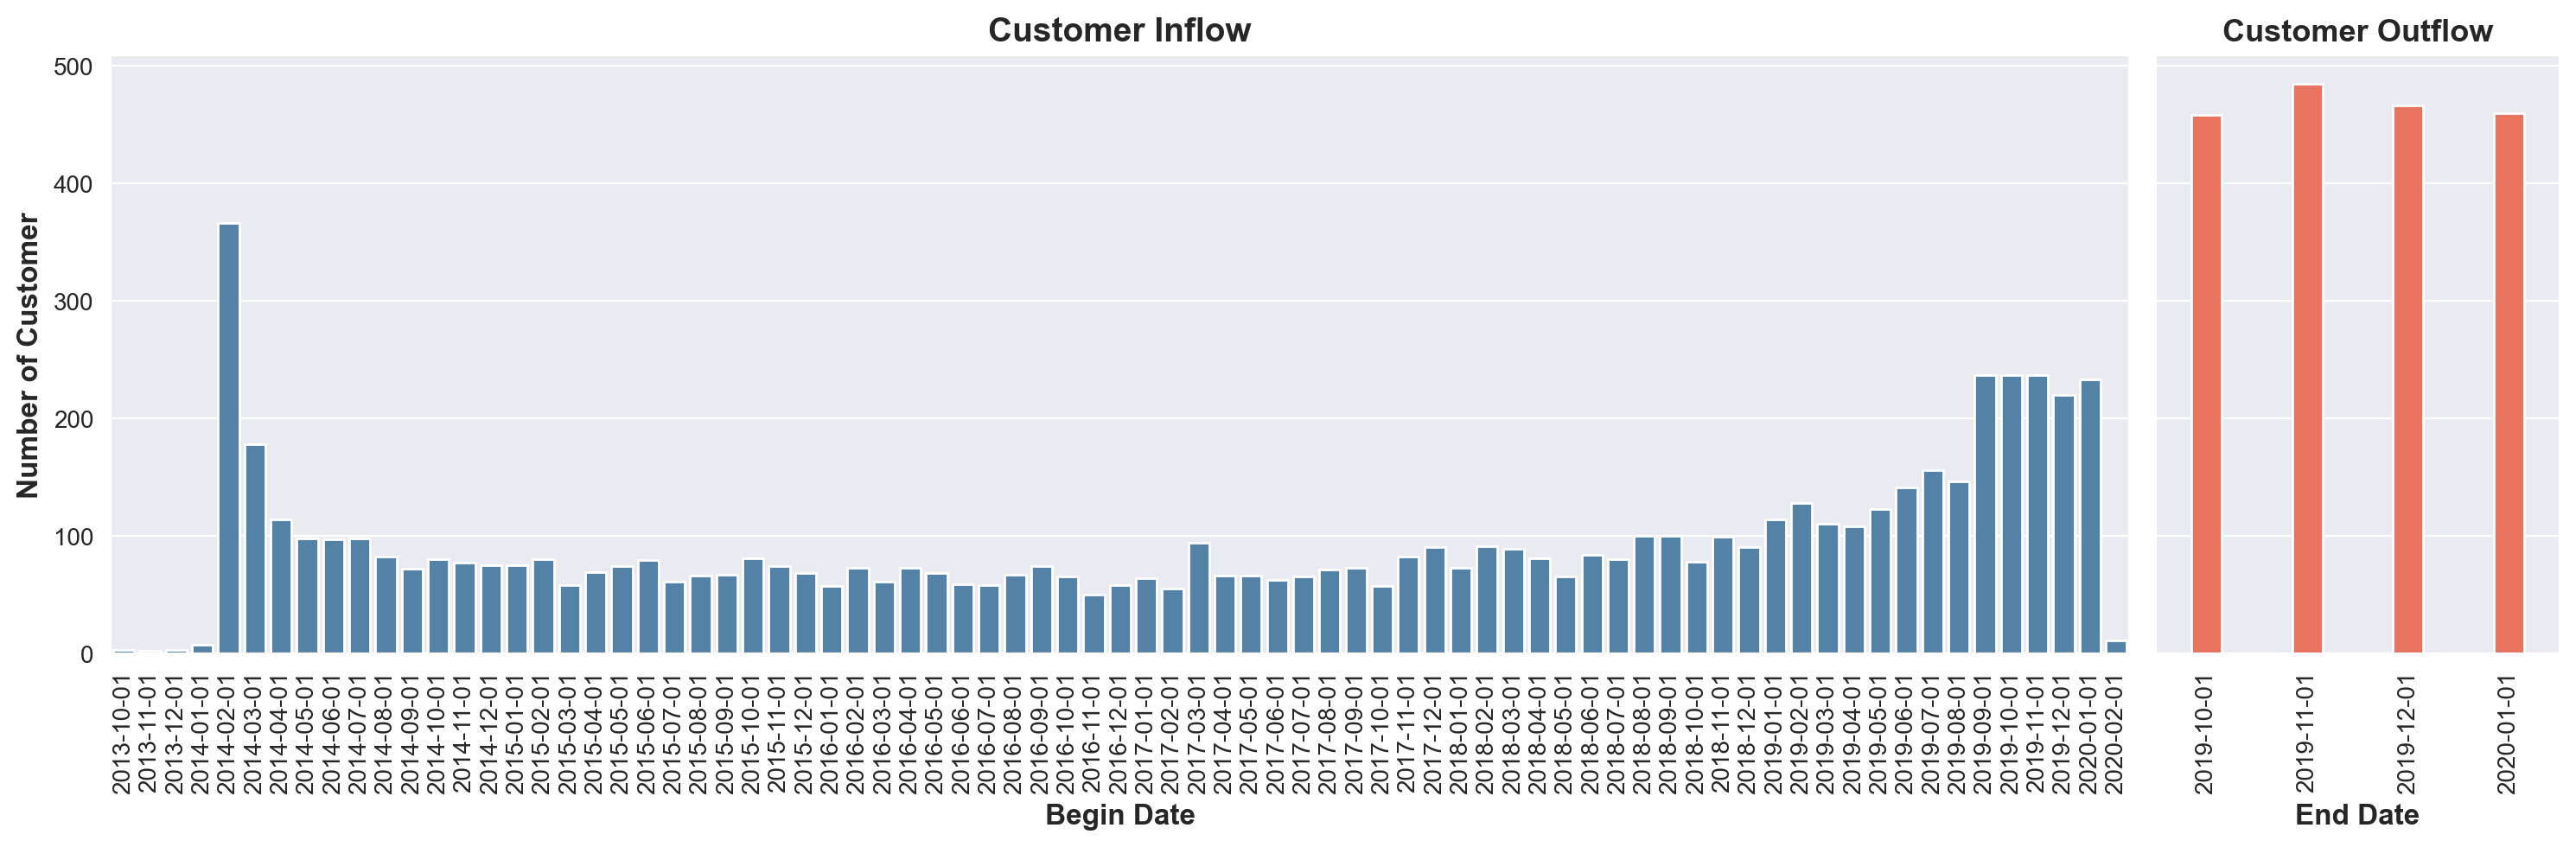

In [61]:
# Plot bar charts to view the customer joining and leaving dates
sns.set_style('darkgrid')
fig, axs = plt.subplots(1, 2, width_ratios=[5.0, 1.0], sharey=True, figsize=(15, 5))

# The joining dates
df_t = df_all['begin_date'].value_counts().sort_index()
ax = axs[0]
sns.barplot(x=df_t.index, y=df_t.values, color='steelblue', ax=ax)
ax.set_title('Customer Inflow', fontsize=14, fontweight='bold')
ax.set_xlabel('Begin Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Customer', fontsize=12, fontweight='bold')
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

# The leaving dates
df_t = df_all['end_date'].value_counts().sort_index()
ax = axs[1]
sns.barplot(x=df_t.index, y=df_t.values, color='tomato', width=0.3, ax=ax)
ax.set_title('Customer Outflow', fontsize=13, fontweight='bold')
ax.set_xlabel('End Date', fontsize=12, fontweight='bold')
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

The customers started joining the company services at `2013-10-01`. In February of 2014, the telecom operator have acquired the most number of customers, which was around 360. Since then, the inflow of customer maintain at roughly 50 to 150 per month until August of 2019. The newly acquired customers have increased to about 220 from September of 2019 until the date when data was extracted. However, the customers also started to leave from October of 2019 and the amount of leaving customers are almost doubled the amount of joining customers.

[Back to Contents](#back)

### 6.4 Distribution of Key Variables Per Service Type <a id='key_variables'></a>

In [62]:
# Get the list of numerical columns
numerical_columns = ['monthly_charges', 'total_charges', 'subscribed_days', 'subscribed_years']

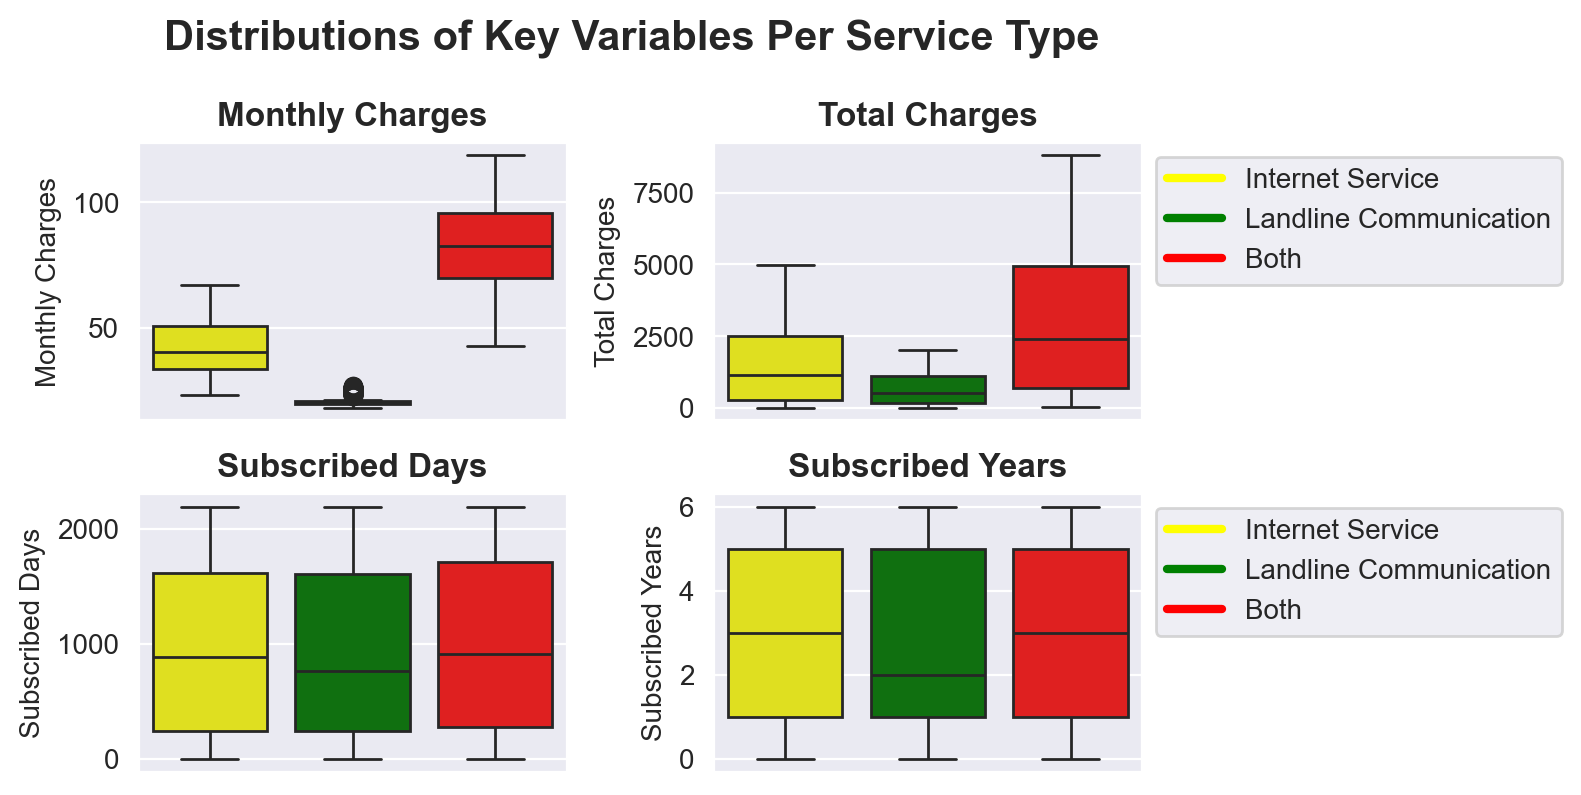

In [63]:
# Plot boxplots to show the distributions
nrows, ncols = 2, 2
sns.set_style('darkgrid')
palette = ['yellow', 'green', 'red']

fig, axs = plt.subplots(nrows, ncols, figsize=(8, 4))

plt.suptitle('Distributions of Key Variables Per Service Type', x=0.4, fontsize=15, fontweight='bold')

for i in range(nrows):
    for j in range(ncols):
        idx = i*ncols + j
        variable = numerical_columns[i*ncols + j]
        variable_name = ' '.join([word.capitalize() for word in variable.split('_')])
        
        ax = axs[i][j]
        sns.boxplot(data=df_all, x='subscribed_service', y=variable, hue='subscribed_service',
                    order=['internet_service', 'landline_communication', 'both'],
                    hue_order=['internet_service', 'landline_communication', 'both'],
                    legend=False, palette=palette, ax=ax)
        ax.set_title(variable_name, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel(variable_name)
        ax.set_xticks([])
        if j == 1:
            legend_labels = ['Internet Service', 'Landline Communication', 'Both']
            legend_handles = [Line2D([0], [0], color=palette[0], lw=3),
                              Line2D([0], [0], color=palette[1], lw=3),
                              Line2D([0], [0], color=palette[2], lw=3)]
            ax.legend(legend_handles, legend_labels, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

Customers who subscribed to both services pay substantially more than those who subscribed to only one of the services. The subscription periods for customers using only the landline communication service are slightly lower than those in the other two groups.

[Back to Contents](#back)

### 6.5 Churn Rate Per Categorical Feature <a id='categorical_features'></a>

**Churn Rate Per Contract Type**

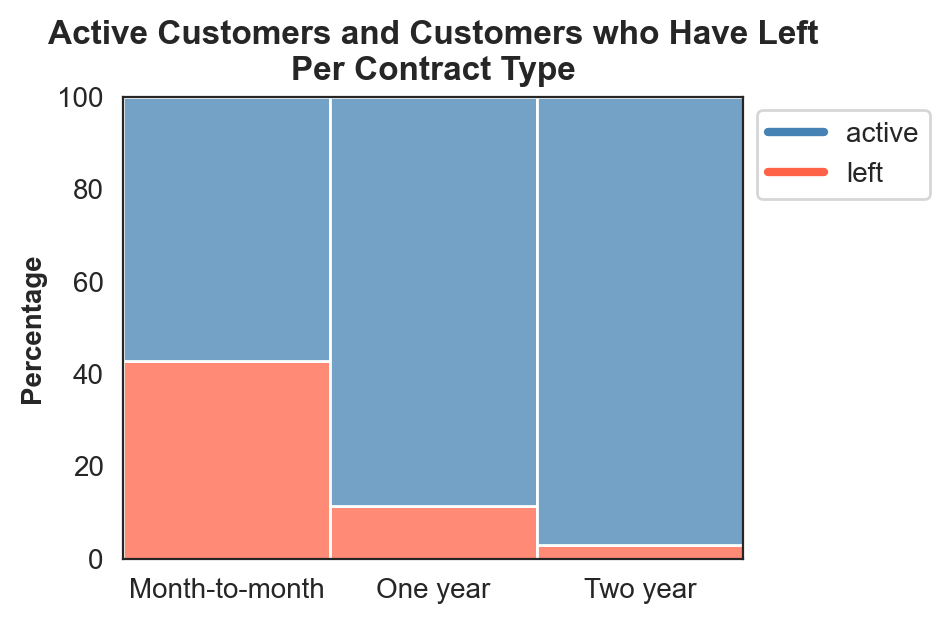

In [64]:
# Plot a filled bar chart
sns.set_style('white')
plt.figure(figsize=(4, 3))

ax = plt.gca()
plot_filled_bar_chart(data=df_all,
                      x='type',
                      title='Active Customers and Customers who Have Left\nPer Contract Type')

plt.show()

The churn rate from the customers with month-to-month contracts is at least four times the churn rates from the other two groups. The marketing department could work on converting these customers to one-year or two-year contracts.

**Churn Rate Per Service Relevant Feature**

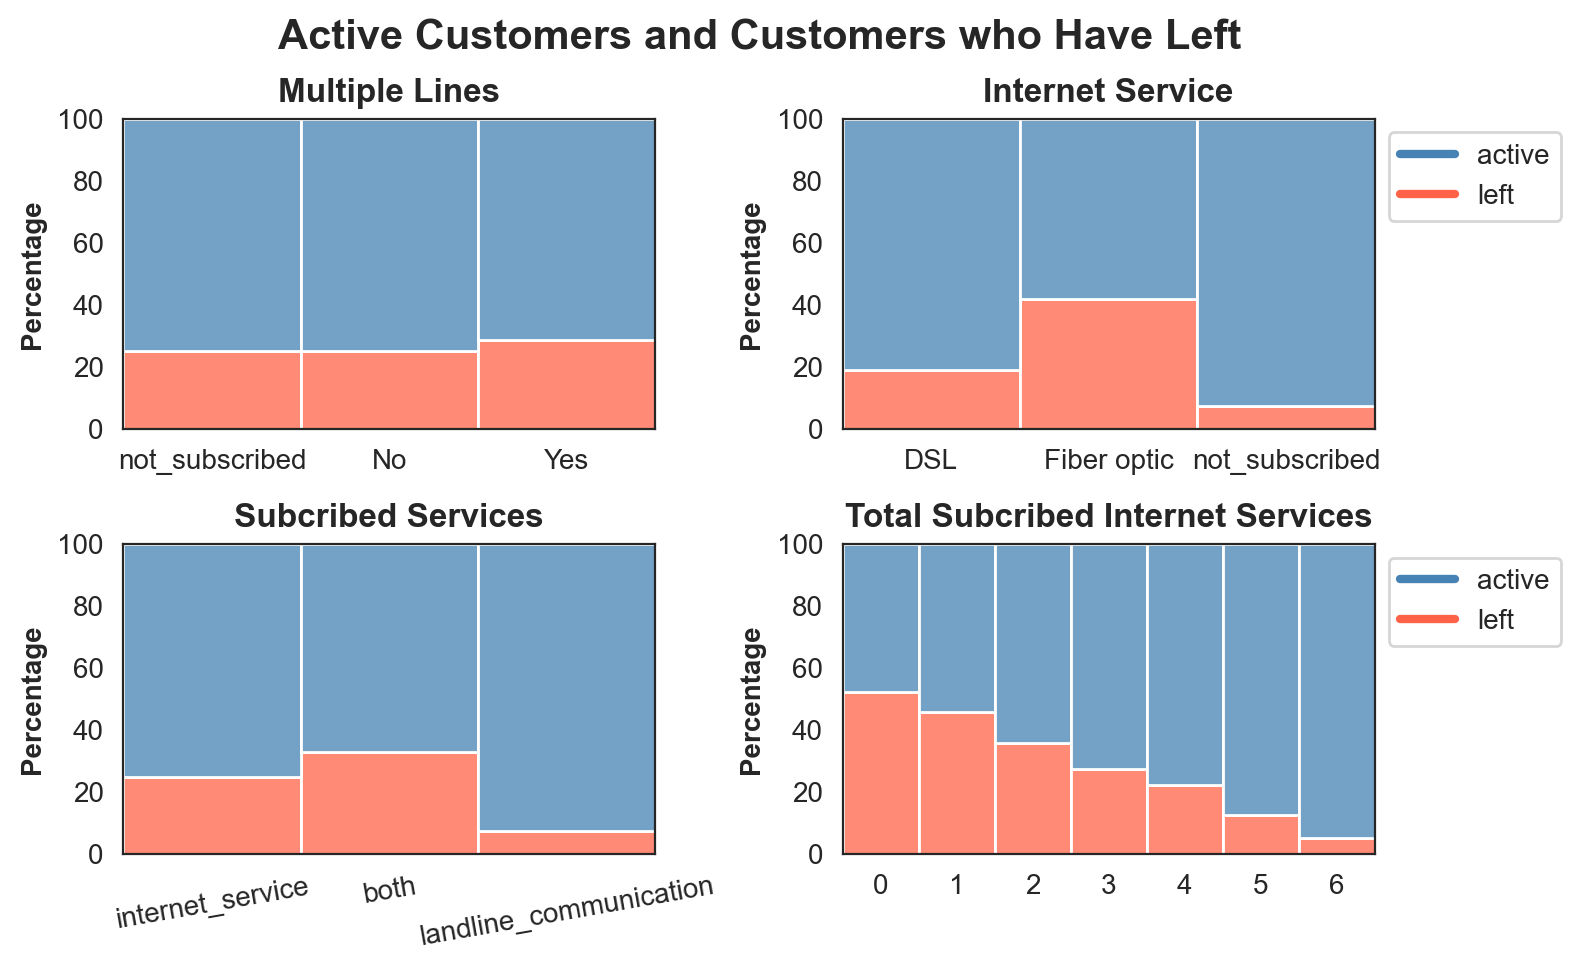

In [65]:
# Plot  filled bar charts
sns.set_style('white')
fig, axs = plt.subplots(2, 2, figsize=(8, 5))

plt.suptitle('Active Customers and Customers who Have Left', x=0.48, y=0.96, fontsize=15, fontweight='bold')

ax = axs[0][0]
plot_filled_bar_chart(data=df_all,
                      x='multiple_lines',
                      title='Multiple Lines',
                      legend=False)

ax = axs[0][1]
plot_filled_bar_chart(data=df_all,
                      x='internet_service',
                      title='Internet Service',
                      legend=True)

ax = axs[1][0]
plot_filled_bar_chart(data=df_all,
                      x='subscribed_service',
                      title='Subcribed Services',
                      legend=False)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=10)

ax = axs[1][1]
plot_filled_bar_chart(data=df_all.query('internet_service != "not_subscribed"'),
                      x='total_internet_services',
                      title='Total Subcribed Internet Services',
                      legend=True)
ax.set_xticks(np.arange(0, 7), np.arange(0, 7))
ax.set_xlim(-0.5, 6.5)

plt.tight_layout()
plt.show()

With or without using multiple lines, the churn rate is about 20%. On the other hand, the churn rate for the fiber optic serivce is noticeably higher than that for the DSL service. This raises a red flag considering the larger user base in the fiber optic service.

Surprisingly, the customers who have subscribed to both the internet and landline communication services exhibit higher churn rates. For customers with the internet subscription, the more additional internet services they use, the less likely they will churn.

**Churn Rate Per Additional Internet Service**

In [66]:
# Get the list of service relevant features
internet_services = ['online_security', 'online_backup', 'device_protection',
                     'tech_support', 'streaming_tv', 'streaming_movies']

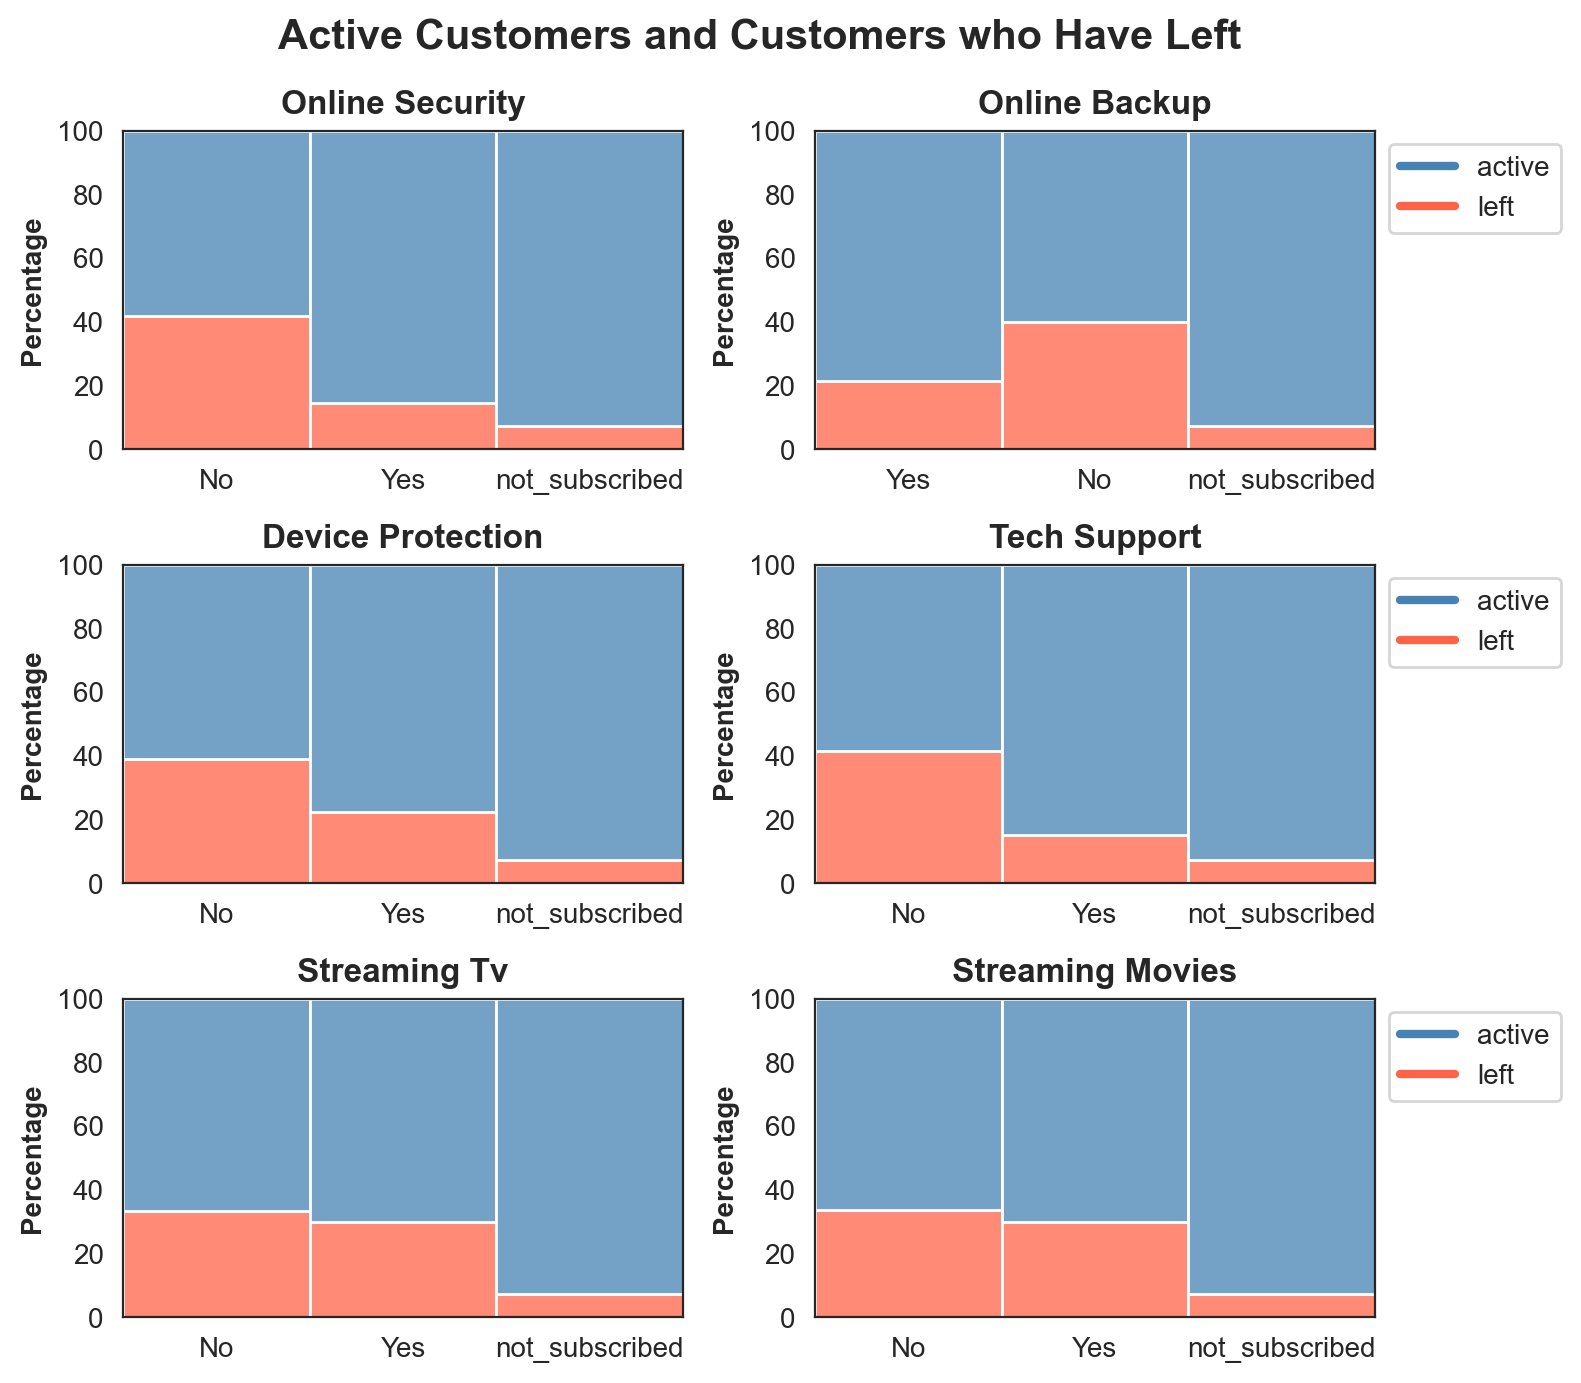

In [67]:
# Plot filled bar charts
nrows, ncols = 3, 2
sns.set_style('white')
fig, axs = plt.subplots(nrows, ncols, figsize=(8, 7))

plt.suptitle('Active Customers and Customers who Have Left', x=0.48, fontsize=15, fontweight='bold')

for i in range(nrows):
    for j in range(ncols):
        ax = axs[i][j]
        # Get the service column name
        service = internet_services[i*ncols + j]
        title = ' '.join([word.capitalize() for word in service.split('_')])

        # Plot the filled bar charts, show legend only for right-hand side bar chart
        if j == 0:            
            plot_filled_bar_chart(data=df_all,
                                  x=service,
                                  title=title,                                  
                                  legend=False)
        if j == 1:            
            plot_filled_bar_chart(data=df_all,
                                  x=service,
                                  title=title,                                  
                                  legend=True)

plt.tight_layout()
plt.show()

For all the additional internet services, each additional subscription lowers the customer churn rate. However, the difference is not distinct for the `streaming_tv` and `streaming_movies` services.

**Churn Rate Per Payment Relevant Behaviour**

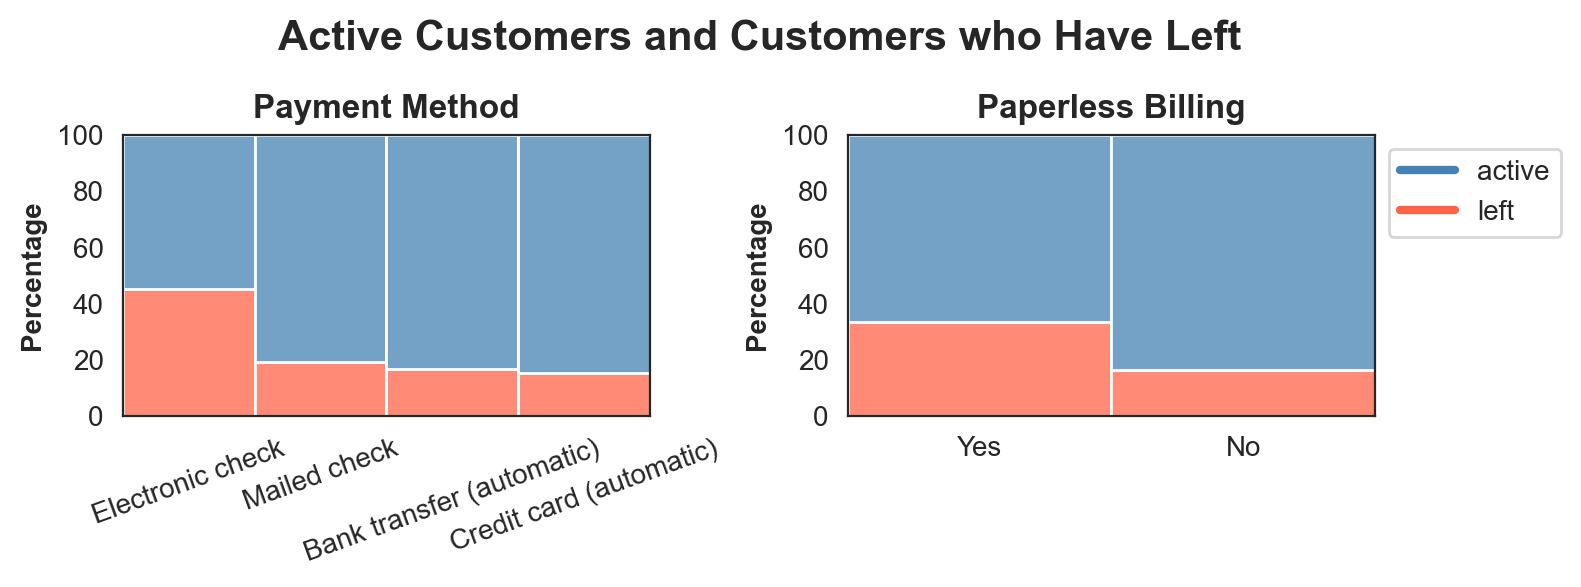

In [68]:
# Plot  filled bar charts
sns.set_style('white')
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

plt.suptitle('Active Customers and Customers who Have Left', x=0.48, y=0.96, fontsize=15, fontweight='bold')

ax = axs[0]
plot_filled_bar_chart(data=df_all,
                      x='payment_method',
                      title='Payment Method',
                      legend=False)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=20)

ax = axs[1]
plot_filled_bar_chart(data=df_all,
                      x='paperless_billing',
                      title='Paperless Billing',
                      legend=True)

plt.tight_layout()
plt.show()

The chance of leaving the telecom operator is doubled for those using electronic check and paperless billing to make the payment.

**Churn Rate Per Personal Characteristic**

In [69]:
# Get the list of personal characteristics
personal_columns = ['gender', 'senior_citizen', 'partner', 'dependents']

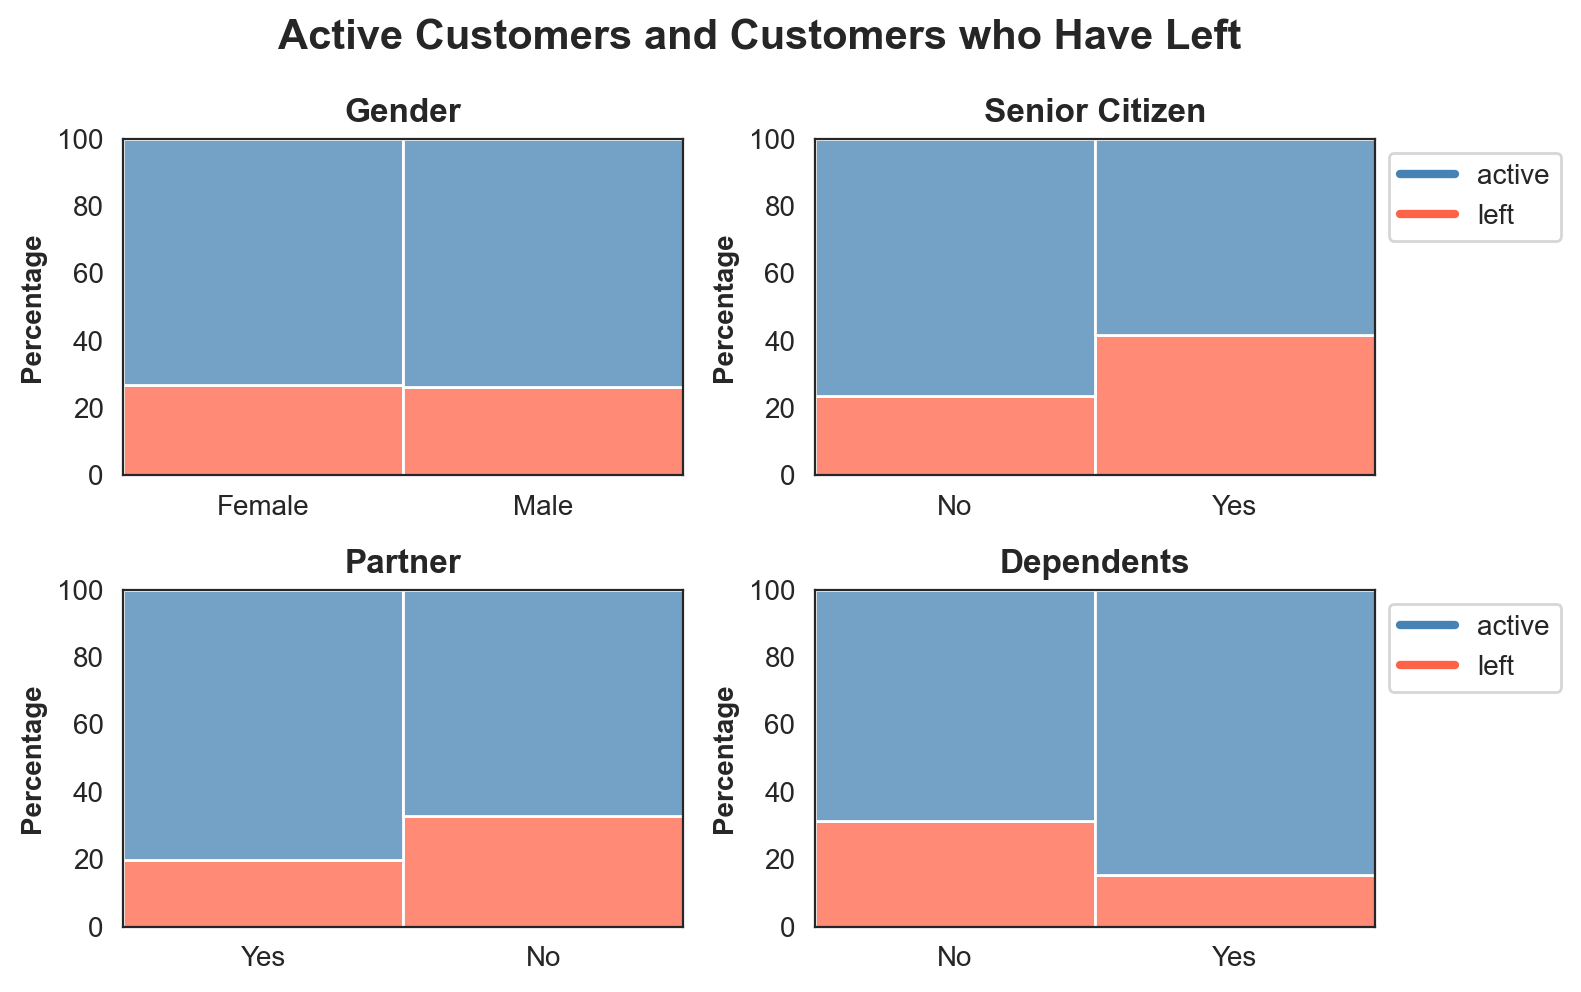

In [70]:
# Plot filled bar charts
nrows, ncols = 2, 2
sns.set_style('white')
fig, axs = plt.subplots(nrows, ncols, figsize=(8, 5))

plt.suptitle('Active Customers and Customers who Have Left', x=0.48, fontsize=15, fontweight='bold')

for i in range(nrows):
    for j in range(ncols):
        ax = axs[i][j]
        # Get the service column name
        personal = personal_columns[i*ncols + j]
        title = ' '.join([word.capitalize() for word in personal.split('_')])

        # Plot the filled bar charts, show legend only for right-hand side bar chart
        if j == 0:            
            plot_filled_bar_chart(data=df_all,
                                  x=personal,
                                  title=title,
                                  legend=False)
        if j == 1:
            service = internet_services[i*ncols + j]
            plot_filled_bar_chart(data=df_all,
                                  x=personal,
                                  title=title,
                                  legend=True)

axs[0][1].set_xticks(np.arange(0, 2), ['No', 'Yes'])

plt.tight_layout()
plt.show()

From the bar charts, we know that
- The gender does not have effect on the churn rate.
- The senior citizen are more likely to leave. We could investigate if the churn rate is age relevant if we had the age data.
- The churn rate is lower among the customers with partner or dependents.

[Back to Contents](#back)

### 6.6 Correlation Coefficients of Numerical Features and Target <a id='correlation'></a>

In [71]:
# Get the list of numerical features
numerical_features = ['monthly_charges', 'total_charges', 'subscribed_days',
                      'subscribed_years', 'total_internet_services']

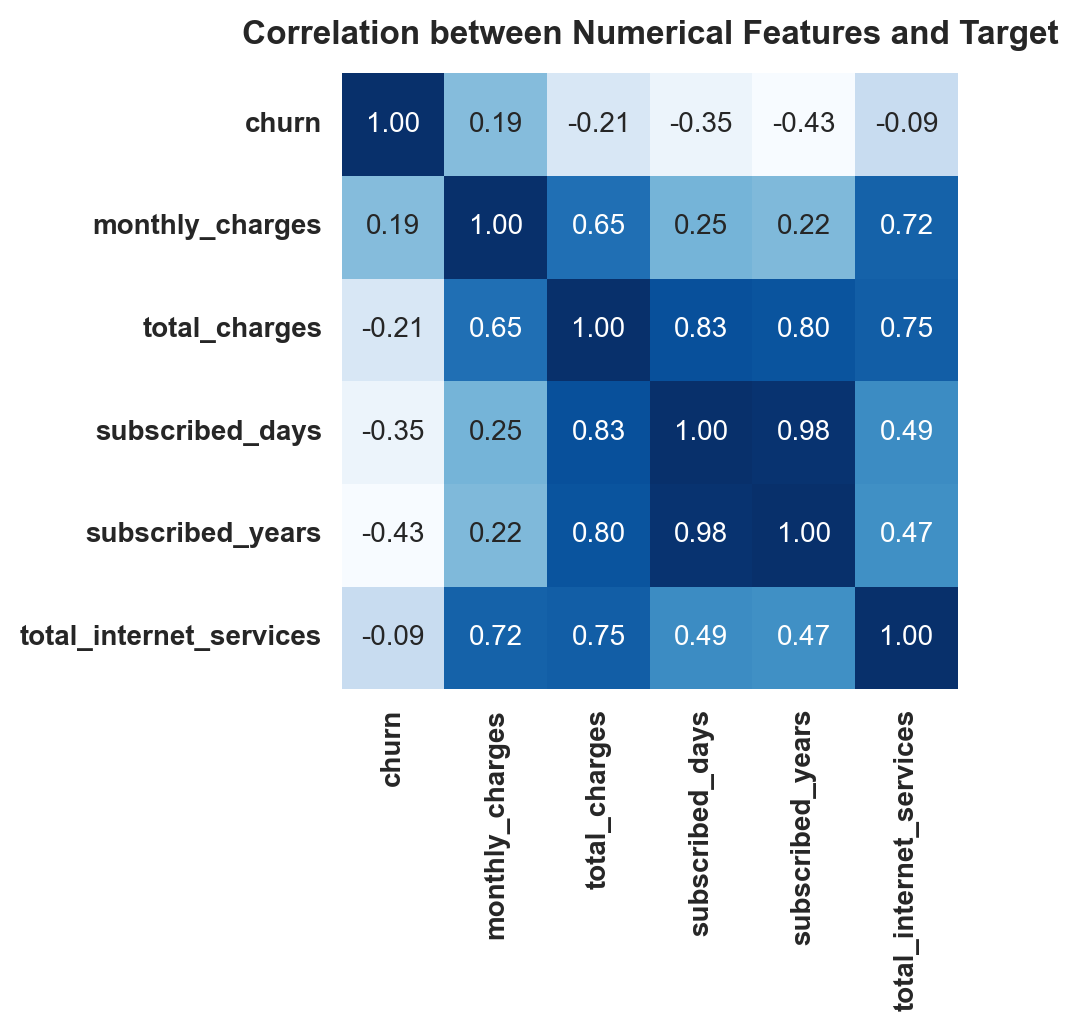

In [72]:
# Plot the heatmap of correlation coefficients
sns.set_style('white')
plt.figure(figsize=(4, 4))

corr_data = df_all[['churn'] + numerical_features].corr()

sns.heatmap(corr_data, annot=True, fmt='.2f',
            cmap='Blues', square=True, cbar=False)

plt.title('Correlation between Numerical Features and Target',
          fontsize=12, fontweight='bold', y=1.02)
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.show()

From the correlation coefficients, it can be seen that 
- The `subscribed_days` and `subscribed_years` have moderate indirect relationship with the target `churn`.
- The `monthly_charges` and `total_charges` have weak relationship with the target.
- The `total_internet_services` has no linear relationship with the target.

[Back to Contents](#back)

### 6.7 Distributions of Numercical Features Per Target Class <a id='numerical_features'></a>

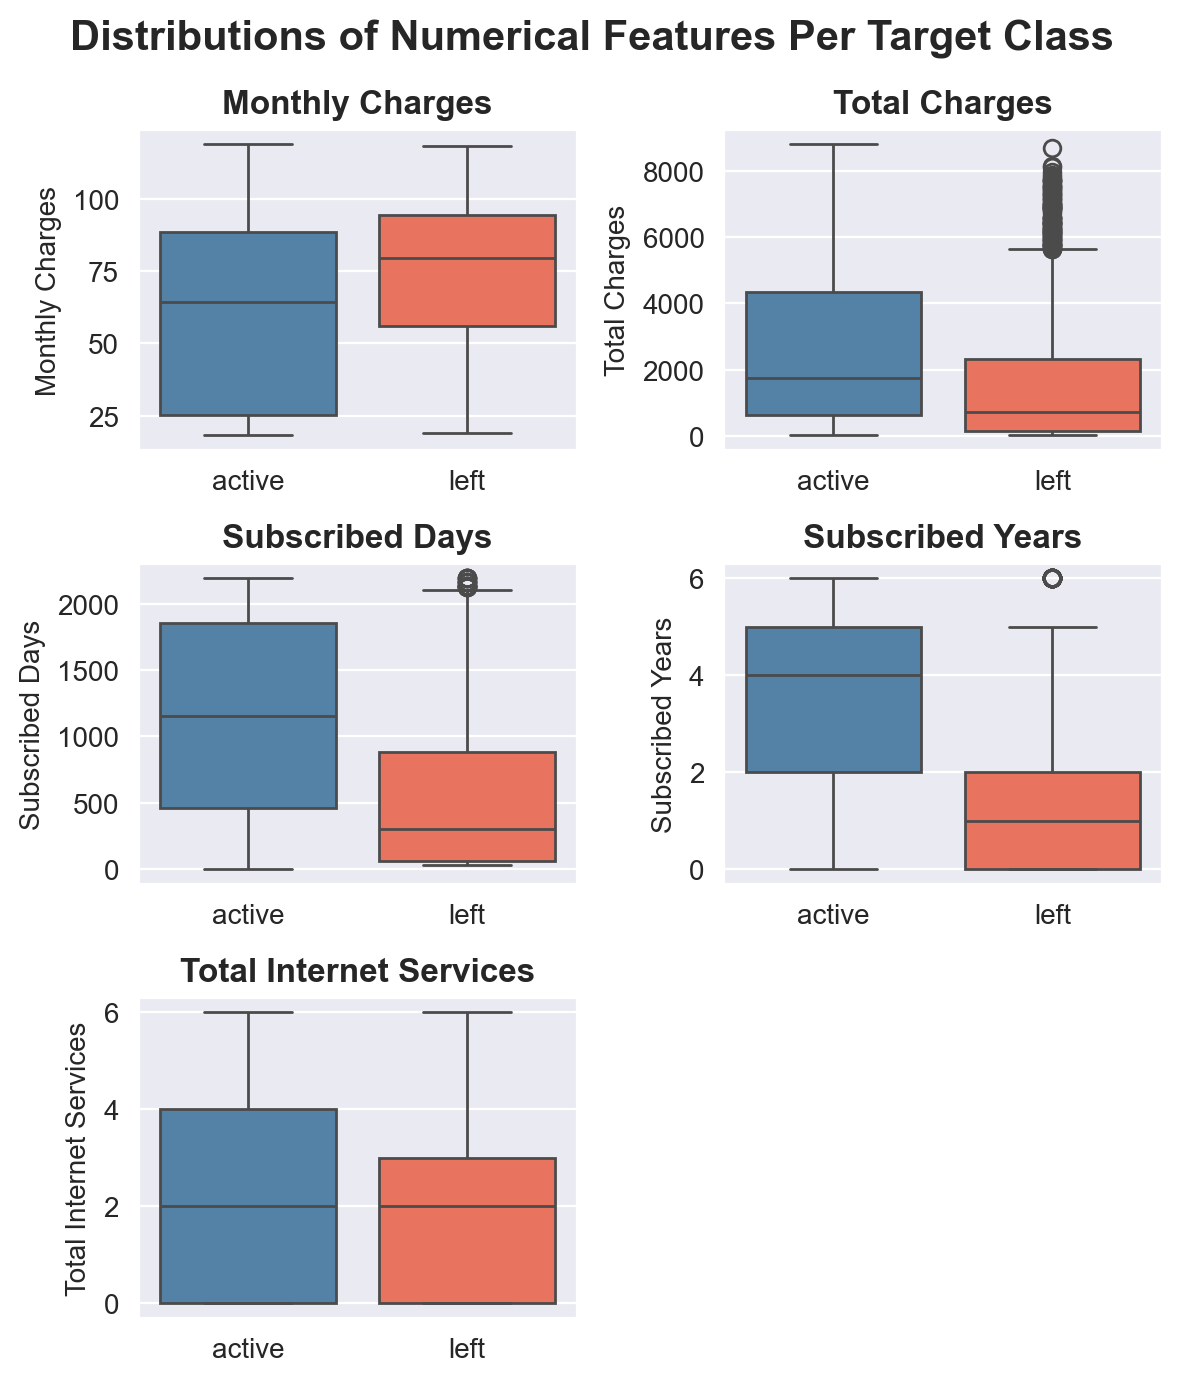

In [73]:
# Plot boxplots to show the distributions
nrows, ncols = 3, 2
sns.set_style('darkgrid')
palette=['steelblue', 'tomato']

fig, axs = plt.subplots(nrows, ncols, figsize=(6, 7))

plt.suptitle('Distributions of Numerical Features Per Target Class', fontsize=15, fontweight='bold')

for i in range(nrows):
    for j in range(ncols):
        idx = i*ncols + j
        ax = axs[i][j]
        
        if idx < len(numerical_features):
            feature = numerical_features[idx]
            feature_name = ' '.join([word.capitalize() for word in feature.split('_')])            
            
            sns.boxplot(data=df_all, x='churn', y=feature, hue='churn', legend=False,
                        palette=palette, ax=ax)
            ax.set_title(feature_name, fontweight='bold')
            ax.set_xlabel('')
            ax.set_ylabel(feature_name)
            ax.set_xticks([0, 1], ['active', 'left'])
        else:
            sns.set_style('white')
            ax.axis(False)
            
plt.tight_layout()
plt.show()

All the numerical features are good predictors except the `total_internet_services`.

[Back to Contents](#back)

### 6.8 Distribution of Target Classes <a id='target_classes'></a>

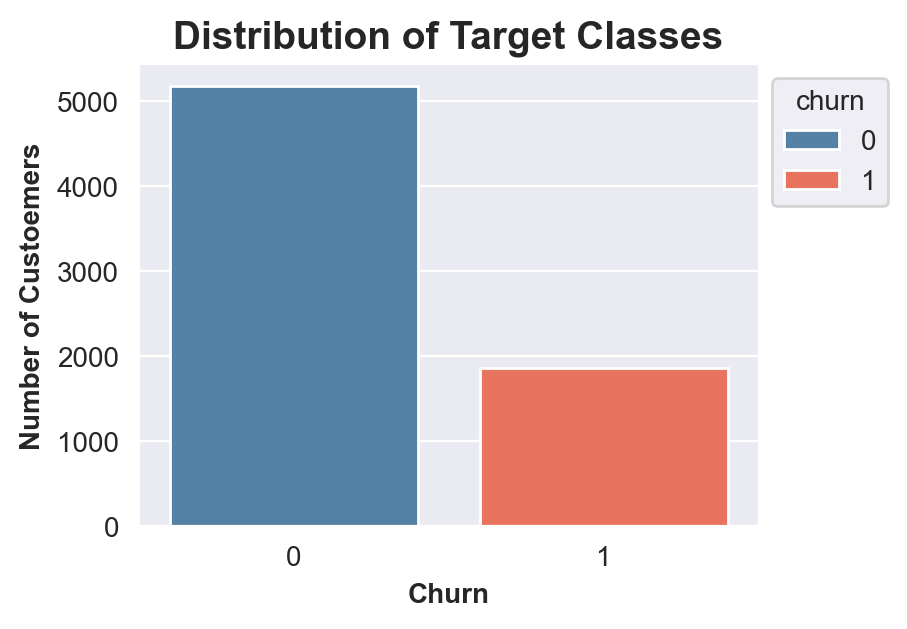

churn
0    0.7346
1    0.2654
Name: proportion, dtype: float64

In [74]:
# Plot bar chart to visualise the distribution of target classes
sns.set_style('darkgrid')
plt.figure(figsize=(4, 3))

sns.countplot(data=df_all, x='churn', hue='churn', palette=['steelblue', 'tomato'])
plt.legend(title='churn', loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Distribution of Target Classes', fontsize=14, fontweight='bold')
plt.xlabel('Churn', fontweight='bold')
plt.ylabel('Number of Custoemers', fontweight='bold')

plt.show()

# Calculate the percentage of each class
display(df_all['churn'].value_counts(normalize=True).round(4))

The target classes are heavily imbalanced, there are 73.46% of active customers and 26.54% of customers who have left. As a result, the dataset will be upsampled before training the model.

[Back to Contents](#back)

### 6.9 Conclusion <a id='eda_conclusion'></a>

After analysing the customer characteristics and behaviours, the results are summarised and concluded as follows.

1. The customers who have left tend to have a higher monthly payment. The customers with a monthly payment of `70-110` have a higher churn rate of 36.79% compared to the other customers.
2. Most of the customers (68.65%) subscribed for both the landline communication and internet services.
3. Although there was a great increament in the number of acquired customers since September of 2019, the number of leaving customers was doubled than the joining customers.
4. Among the internet service users, fiber optic is the main choice but the churn rate from this service is also significantly higher, compared to the DSL users.
5. The customer using only the landline communication service have a slightly shorter subscription duration.
6. The churn rate from the customers with month-to-month contracts is at least four times the churn rates from the other two groups.
7. While the churn rate is higher among the users who subcribed for both services, the customers are less likely to leave when they subscribe more additional internet services.
8. The churn rate among the customers using electronic check and paperless billing to make the payment is twice the churn rate among the customers using other payment methods.
9. The elder people are more likely to leave the telecom operator. On the other hand, the customers with partner or dependents are less likely to terminate the services.
10. The longer the subscription duration, the lower the chance of leaving the telecom operator.
11. The target classes are imbalanced, with 73.46% of active customers and 26.54% of customers who have left.

[Back to Contents](#back)

## 7. Modeling <a id='modeling'></a>

The following functions will automate the tasks in this stage.

In [75]:
def optimise_model(model, objective, X_train, y_train, X_val, y_val, n_trials, model_name):    
    '''
    Optimise a scikit-learn model with the Optuna library.

    The model is optimised based on a user-defined objective function.

    Parameters
    ----------
    model : class
        The scikit-learn model class (e.g., LogisticRegression, DecisionTree, etc.) that 
        needs to be optimised.
    objective : function
        The objective function to be minimised or maximised during optimisation. This function should 
        take a single argument `trial` object, and it should return a numerical score to be optimised.
    X_train : array-like of shape (n_samples, n_features)
        The data to be used for training the model.
    y_train : array-like of shape (n_samples,)
        The target variable of training set.
    X_val : array-like of shape (n_samples, n_features)
        The data to be used for model evaluation.
    y_val : array-like of shape (n_samples,)
        The target variable of validation set.
    n_trials : int
        The number of trials (iterations) for the optimisation process.
    model_name : str
        A string representing the name of the model.

    Returns
    -------
    tuple
        A tuple containing the optimised model and training time.
        
    Examples
    --------    
    >>> from sklearn.linear_model import LogisticRegression
    >>> from sklearn.model_selection import cross_val_score

    >>> def objective(trial):
    >>>     # Define your objective function to be minimised or maximised        
    >>>     C = trial.suggest_float('C', 1e-3, 1e1, log=True)        
        
    >>>     clf = LogisticRegression(C=C)
    >>>     # Assume X_train, y_train are defined
    >>>     accs = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
        
    >>>     # Return a numerical score to be minimised or maximised
    >>>     return accs.mean()

    >>> # Assume X_train, y_train are defined
    >>> best_model, train_time = optimise_model(LogisticRegression, objective,
    ...                                         X_train, y_train, X_val, y_val,
    ...                                         n_trials=50, model_name='MyLogisticRegression')
    '''
    # Set the optuna verbosity level to warning only
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    # Create the optimisation study
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42),
                                direction='maximize',
                                study_name=f'{model_name}_study')    

    # Optimise the model and show the progress bar
    with tqdm(total=n_trials, desc=f'Optimising {model_name}... ') as pbar:
        def callback(study, trial):
            pbar.update(1)    
        study.optimize(objective, n_trials=n_trials, callbacks=[callback])

    # Print the best hyperparameter found
    print('Best hyperparameters:')
    display(study.best_params)    
    print()
    
    # Recreate the best model
    best_model = model(**study.best_params) 

    # Train the model and record the training time          
    train_start = time.time()
    best_model.fit(X_train, y_train)
    train_end = time.time()
    train_time = round((train_end - train_start) * 1000, 2)

    return best_model, train_time

In [76]:
def evaluate_model(model, X_train, y_train, X_test, y_test, test_set=False):
    '''
    Evaluate the performance of a binary classification model.

    Evaluate the model performance on the training and test sets.
    Display the scores including ROC AUC score and accuracy score.
    Plot the ROC curve and confusion matrix.
    
    Parameters:
    -----------
    model : object
        The trained binary classification model (sklearn or keras).
    X_train : array-like of shape (n_samples, n_features)
        Features of the training set.
    y_train : array-like of shape (n_samples,)
        Labels of the training set.
    X_test : array-like of shape (n_samples, n_features)
        Features of the test set.
    y_test : array-like of shape (n_samples,)
        Labels of the test set.
    test_set : bool, default False
        Control the result to be shown or returned for validation set
        and test set.

    Returns:
    --------
    dict
        Dictionary containing evaluation results:
        - 'train_roc_auc' (float): ROC AUC score on the training set.
        - 'test_roc_auc' (float): ROC AUC score on the test set.
        - 'train_acc' (float): Accuracy score on the training set.
        - 'test_acc' (float): Accuracy score on the test set.
        - 'prediction_time (ms)' (float): Prediction time on the test set in milliseconds.

    Examples:
    ---------
    >>> from sklearn.linear_model import LogisticRegression
    >>> from sklearn.model_selection import train_test_split
    >>> model = LogisticRegression()
    >>> # Assume X, y are defined
    >>> X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    >>> evaluation_results = evaluate_model(model, X_train, y_train, X_test, y_test)
    >>> print(evaluation_results)
    {'train_roc_auc': 0.9, 'val_roc_auc': 0.85, 'train_acc': 0.88, 'val_acc': 0.86, 'prediction_time (ms)': 15}
    '''
    # Create a dictionary to store the evaluation stats
    eval_stats = {}

    # Plot the ROC curve and confusion matrix
    sns.set_style('darkgrid')
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    for data_type, X, y in (('train', X_train, y_train), ('test', X_test, y_test)):     
        # Create dict to store the train and test stats
        eval_stats[data_type] = {}

        # Get the predict probability and predictions
        # Calculate the prediction time
        pred_proba = model.predict_proba(X)[:, 1]
        pred_start = time.time()
        y_pred = model.predict(X)
        pred_end = time.time()

        # Store the prediction time on the test set
        if data_type == 'test':
            pred_time = round((pred_end - pred_start) * 1000, 2)

        # Get the required data to plot the ROC curve
        fpr, tpr, roc_thresholds = roc_curve(y, pred_proba)
        roc_auc = roc_auc_score(y, pred_proba)        
                
        # Assign colours for train and test sets in the graph
        if data_type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Plot the ROC curve
        ax = axs[0]
        if data_type == 'train':
            ax.plot(fpr, tpr, color=color, label=f'train, ROC AUC={roc_auc:.4f}')
        else:
            if not test_set:
                ax.plot(fpr, tpr, color=color, label=f'val, ROC AUC={roc_auc:.4f}')
            else:
                ax.plot(fpr, tpr, color=color, label=f'test, ROC AUC={roc_auc:.4f}')
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_title('ROC Curve', fontsize=12, fontweight='bold')
        ax.set_xlabel('FPR', fontweight='bold')
        ax.set_ylabel('TPR', fontweight='bold')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.legend(loc='lower center', prop={'size': 8, 'weight': 'bold'})
        
        # Make a few point on the curve with selected thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx],
                    color=marker_color, marker='X', markersize=7)

        # Plot the confusion matrix on the test set
        if data_type == 'test':
            ax = axs[1]
            sns.heatmap(confusion_matrix(y, y_pred), cmap='Blues', annot=True, square=True,
                        fmt='.0f', annot_kws={'fontsize': 12, 'fontweight': 'bold'}, cbar=False, ax=ax)
            ax.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
            ax.set_xlabel('Predicted', fontweight='bold')
            ax.set_ylabel('Actual', fontweight='bold')
            ax.set_xticks([0.5, 1.5], ['Active', 'Left'])
            ax.set_yticks([0.5, 1.5], ['Active', 'Left'])
        
        # Store the ROC AUC score and accuracy_score
        eval_stats[data_type]['ROC AUC'] = roc_auc
        eval_stats[data_type]['Accuracy'] = accuracy_score(y, y_pred)

    plt.tight_layout()
    plt.show()
    
    # Get the evaluation result to be shown
    eval_stats_df = pd.DataFrame(eval_stats)
    eval_stats_df = eval_stats_df.round(4).reindex(index=('ROC AUC', 'Accuracy'))    

    # Return the evaluation result as necessary
    if not test_set:
        result = {
            'train_roc_auc': eval_stats_df.loc['ROC AUC', 'train'],
            'val_roc_auc': eval_stats_df.loc['ROC AUC', 'test'],
            'train_acc': eval_stats_df.loc['Accuracy', 'train'],
            'val_acc': eval_stats_df.loc['Accuracy', 'test'],
            'prediction_time (ms)': pred_time
        }

        # Adjust the column names and show the evaluation result
        eval_stats_df.columns = ['train', 'validation']
        display(eval_stats_df)
        
        return result        
    else:
        # Show the evaluation result
        display(eval_stats_df)

In [77]:
def save_model(model, model_path, model_name):
    '''
    Save the trained model.
    '''
    # Delete the model if it exists
    if os.path.isfile(model_path):
        os.remove(model_path)

    # Save the model
    try:
        pickle.dump(model, open(model_path, 'wb'))        
    except Exception as e:
        print('Failed to save the model.')
        print(f'Unexpected Error: {e}')
    else:
        print(f'The {model_name} model has been successfully saved.')

---

**Obtain the Features and Target**

To predict the target `churn`, the following six models will be trained.

- Baseline model: Constant Model
- Linear model: Logistic Regression
- Tree-based model: Decision Tree
- Gradient boosting ensemble: LightGBM, CatBoost, XGBoost

Before training the models, the first step is to separate the dataset into the features and target. Also, the following unnecessary features will be dropped.

- `customer_id`: This feature provides no information to predict the target.
- `begin_date` and `end_date`: The neccesary information has been extracted as two additional features `subscribed_days` and `subscribed_years` have been created from these two features.

In [78]:
# Get the features and target
X = df_all.drop(columns=['customer_id', 'begin_date', 'end_date', 'churn'])
y = df_all['churn']

# Check the shapes of X and y
print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of X: (7043, 21)
Shape of y: (7043,)


**One-Hot Encoding**

Although some models (e.g. LightGBM and CatBoost) can handle categorical features internally, we will still perform one-hot encoding on the categorical features to ensure all the models can be trained properly.

In [79]:
# One-hot encode the categorical features
X_ohe = pd.get_dummies(X, drop_first=True, dtype=int)

# Check the shape of X_ohe
print('Shape of X after one-hot encoding:', X_ohe.shape)

Shape of X after one-hot encoding: (7043, 33)


**Split the Dataset into Training, Validation and Test Sets**

Since we do not have a lot of data, we will use 80% of the dataset for training and divide the remaining 20% equally between validation and testing.

In [80]:
# Split the dataset into train:val:test = 80:10:10
X_train, X_test, y_train, y_test = train_test_split(X_ohe, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Check the shapes
print('Shape of X_train', X_train.shape)
print('Shape of y_train', y_train.shape)
print('Shape of X_val', X_val.shape)
print('Shape of y_val', y_val.shape)
print('Shape of X_test', X_test.shape)
print('Shape of y_test', y_test.shape)

Shape of X_train (5634, 33)
Shape of y_train (5634,)
Shape of X_val (704, 33)
Shape of y_val (704,)
Shape of X_test (705, 33)
Shape of y_test (705,)


**Feature Scaling**

For the numerical features, feature scaling by standardisation will be carried out. Even though feature scaling does not affect the predictive performance of the six models in this project, but the gradient boosting models (LightGBM, CatBoost and XGBoost) can converge better and faster after feature scaling since the optimisation algorithm of these models is based on gradient descent.

In [81]:
# Get the list of numercial features
numerical_features = ['monthly_charges', 'total_charges', 'subscribed_days', 'subscribed_years', 'total_internet_services']

In [82]:
# Perform feature scaling
sc = StandardScaler()
X_train[numerical_features] = sc.fit_transform(X_train[numerical_features])
X_val[numerical_features] = sc.transform(X_val[numerical_features])
X_test[numerical_features] = sc.transform(X_test[numerical_features])

In [83]:
# Have a check after feature scaling
display(X_train.head(3))
display(X_val.head(3))
display(X_test.head(3))

,monthly_charges,total_charges,senior_citizen,subscribed_days,subscribed_years,total_internet_services,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),...,tech_support_Yes,tech_support_not_subscribed,streaming_tv_Yes,streaming_tv_not_subscribed,streaming_movies_Yes,streaming_movies_not_subscribed,multiple_lines_Yes,multiple_lines_not_subscribed,subscribed_service_internet_service,subscribed_service_landline_communication
2142,-0.000474,-0.407052,0,-0.464150,-0.440266,0.515663,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1623,1.074754,1.266081,0,0.886385,0.995461,0.515663,0,1,1,0,...,0,0,1,0,1,0,1,0,0,0
6074,-1.376499,-1.009904,0,-1.286039,-1.397417,-1.103761,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0


,monthly_charges,total_charges,senior_citizen,subscribed_days,subscribed_years,total_internet_services,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),...,tech_support_Yes,tech_support_not_subscribed,streaming_tv_Yes,streaming_tv_not_subscribed,streaming_movies_Yes,streaming_movies_not_subscribed,multiple_lines_Yes,multiple_lines_not_subscribed,subscribed_service_internet_service,subscribed_service_landline_communication
457,0.529662,0.051562,0,-0.096922,0.038310,1.595279,0,1,0,0,...,1,0,1,0,1,0,0,0,0,0
2284,-0.297948,-0.926794,0,-1.202639,-0.918841,-0.024145,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
640,-1.311686,-0.300343,0,1.459421,1.474037,-1.103761,0,1,0,0,...,0,1,0,1,0,1,1,0,0,1


,monthly_charges,total_charges,senior_citizen,subscribed_days,subscribed_years,total_internet_services,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),...,tech_support_Yes,tech_support_not_subscribed,streaming_tv_Yes,streaming_tv_not_subscribed,streaming_movies_Yes,streaming_movies_not_subscribed,multiple_lines_Yes,multiple_lines_not_subscribed,subscribed_service_internet_service,subscribed_service_landline_communication
381,-0.472444,-0.998006,0,-1.286039,-1.397417,-0.563953,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
681,0.297000,1.031274,0,1.171558,0.995461,1.055471,0,1,1,0,...,1,0,1,0,1,0,0,0,0,0
4127,-1.331629,-0.386340,0,0.968440,0.995461,-1.103761,0,1,1,0,...,0,1,0,1,0,1,1,0,0,1


The feature scaling process has been done correctly.

**Upsampling the Minority Class of the Training Set**


In the former stage, we have found out that the dataset has imbalanced target classes. To address this issue, we will upsampling the minority class in the training set.

In [84]:
# Check the count of each class before upsampling
y_train.value_counts()

churn
0    4138
1    1496
Name: count, dtype: int64

In [85]:
# Separate the training set into majority class and minority class
X_major = X_train[y_train == 0]
y_major = y_train[y_train == 0]

X_minor = X_train[y_train == 1]
y_minor = y_train[y_train == 1]

# Get the required size for upsampling the minority class
upsize = len(y_major)

# Upsampling the minority class
X_minor_up = X_minor.sample(upsize, replace=True, random_state=42)
y_minor_up = y_minor.sample(upsize, replace=True, random_state=42)

# Combine the majority and minority classes after upsampling and shuffle
X_train_up = pd.concat([X_major, X_minor_up])
y_train_up = pd.concat([y_major, y_minor_up])

X_train_up, y_train_up = shuffle(X_train_up, y_train_up, random_state=42)

In [86]:
# Have a check after upsampling
display(X_train_up.head(3))
display(y_train_up.head(3))

,monthly_charges,total_charges,senior_citizen,subscribed_days,subscribed_years,total_internet_services,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),...,tech_support_Yes,tech_support_not_subscribed,streaming_tv_Yes,streaming_tv_not_subscribed,streaming_movies_Yes,streaming_movies_not_subscribed,multiple_lines_Yes,multiple_lines_not_subscribed,subscribed_service_internet_service,subscribed_service_landline_communication
6380,1.312401,1.903074,1,1.335667,1.474037,1.055471,0,0,1,0,...,0,0,1,0,1,0,1,0,0,0
894,0.542957,1.187192,0,1.253612,1.474037,-0.563953,1,0,1,1,...,1,0,0,0,0,0,1,0,0,0
1029,0.778942,-0.900418,1,-1.202639,-1.397417,0.515663,0,0,1,0,...,1,0,1,0,0,0,0,0,0,0


6380    0
894     0
1029    1
Name: churn, dtype: int64

In [87]:
# Check the count of each class after upsamplint
y_train_up.value_counts()

churn
0    4138
1    4138
Name: count, dtype: int64

[Back to Contents](#back)

### 7.1 Model Training <a id='train_model'></a>

For each model, various hyperparameters will be tuned. The optuna library will be used to search for the best possible model with a limited number of search. In Optuna, the Tree-stuctured Parzen Estimator (TPE) algorithm can be used for sampling hyperparameters during the optimisation process. The TPE algorithm is a Bayesian optimization method which uses a probability distribution to guide the search for optimal hyperparameters.

In [88]:
# Create dictionaries to store various information for later use
best_model = {}
train_time = {}
result = {}

# Create a folder to store the model
model_folder = 'models'
os.makedirs(model_folder, exist_ok=True)

#### 7.1.1 Constant Model <a id='constant'></a>

A constant model which always predict the majority class (`0` in the dataset before upsampling) will be used as a baseline model. No hyperparameter will be tuned.

In [89]:
# Set up for the modeling process
model_name = 'Constant'
opt_model = DummyClassifier

# Create the optuna study objective
def objective(trial):
    # Define the search space
    hyperparameters = {}
    
    # Train and evaluate the model
    model = opt_model(**hyperparameters)
    model.fit(X_train_up, y_train_up)
    val_roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

    return val_roc_auc

# Number of search to find the best model
n_trials = 1

In [90]:
%%time
# Search the best possible model
best_model[model_name], train_time[model_name] = optimise_model(
    opt_model, objective, X_train, y_train, X_val, y_val, n_trials, model_name
)

Optimising Constant... :   0%|          | 0/1 [00:00<?, ?it/s]

Best hyperparameters:


{}


CPU times: total: 46.9 ms
Wall time: 25.9 ms


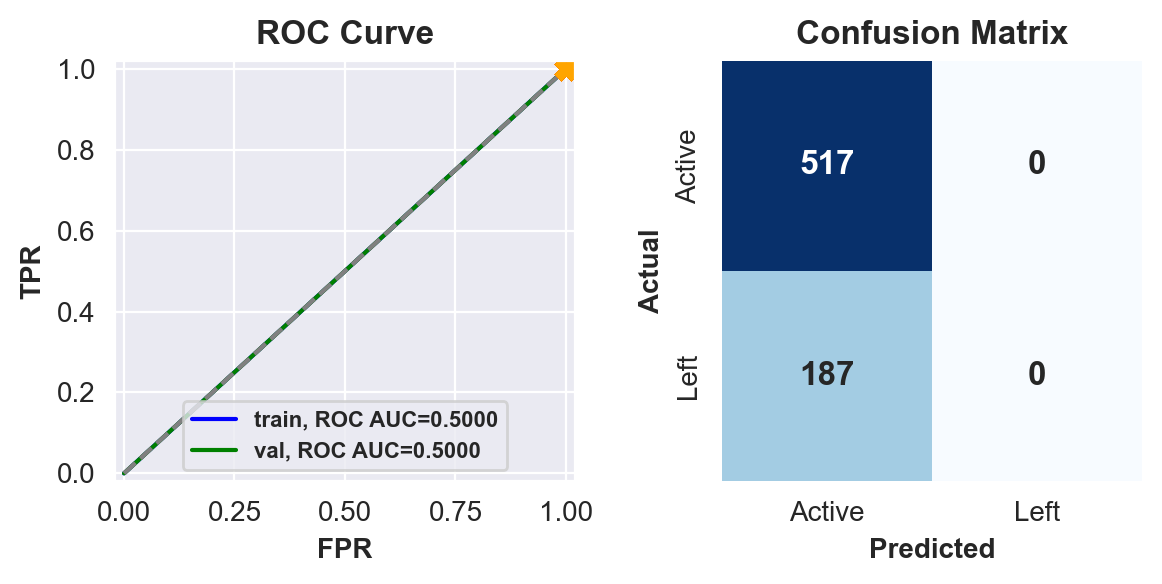

,train,validation
ROC AUC,0.5000,0.5000
Accuracy,0.7345,0.7344


In [91]:
# Evaluate the model and save the result
result[model_name] = evaluate_model(best_model[model_name], X_train, y_train, X_val, y_val)

Since the constant model always predicts the majority class `Active`, the ROC AUC scores for both the training and validation sets are 0.5. The accuracy is the percentage of class `Active` in the respective dataset.

In [92]:
# Create the model saving path
model_path = os.path.join(model_folder, f'{model_name}.pkl')

# Save the model
save_model(best_model[model_name], model_path, model_name)

The Constant model has been successfully saved.


[Back to Contents](#back)

#### 7.1.2 Logistic Regression <a id='lr'></a>

The following hyperparameter will be tuned:

- `C`: The cost of misclassifying labels and it is the inverse of the regularisation strength. The larger the `C`, the more complex the model is and can possibly lead to overfitting.

In [93]:
# Set up for the modeling process
model_name = 'Logistic Regression'
opt_model = LogisticRegression

# Create the optuna study objective
def objective(trial):
    # Define the search space
    hyperparameters = {        
        'C': trial.suggest_float('C', 1e-3, 1e3, log=True),
    }
    
    # Train and evaluate the model
    model = opt_model(**hyperparameters)
    model.fit(X_train_up, y_train_up)
    val_roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

    return val_roc_auc

# Number of search to find the best model
n_trials = 100

In [94]:
%%time
# Search the best possible model
best_model[model_name], train_time[model_name] = optimise_model(
    opt_model, objective, X_train_up, y_train_up, X_val, y_val, n_trials, model_name
)

Optimising Logistic Regression... :   0%|          | 0/100 [00:00<?, ?it/s]

Best hyperparameters:


{'C': 0.1838838202235685}


CPU times: total: 12.6 s
Wall time: 7.36 s


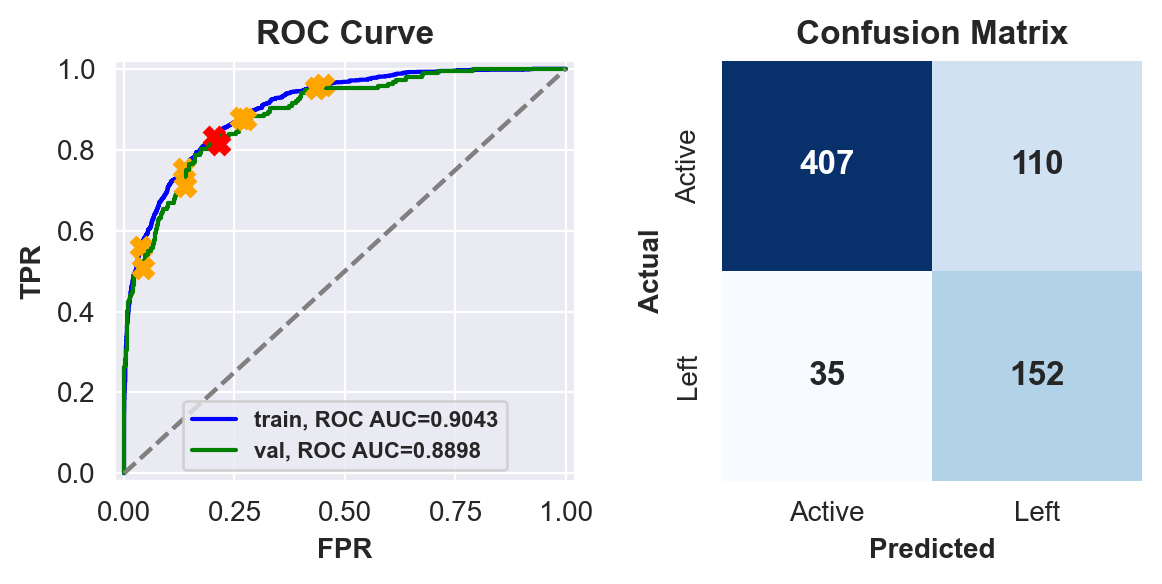

,train,validation
ROC AUC,0.9043,0.8898
Accuracy,0.8137,0.7940


In [95]:
# Evaluate the model and save the result
result[model_name] = evaluate_model(best_model[model_name], X_train_up, y_train_up, X_val, y_val)

The logistic regression model has a validation ROC AUC score of 0.8898. From the confusion matrix, it can be seen that the model does not have a good performance in predicting the majority class `0`.

In [96]:
# Create the model saving path
model_path = os.path.join(model_folder, f'{model_name}.pkl')

# Save the model
save_model(best_model[model_name], model_path, model_name)

The Logistic Regression model has been successfully saved.


[Back to Contents](#back)

#### 7.1.3 Decision Tree <a id='dt'></a>

The following hyperparameter will be tuned:

- `max_depth`: The maximum depth of the decision tree. If the value is too low, the model might not be able to generalise well. However, a high value might cause overfitting.

In [97]:
# Set up for the modeling process
model_name = 'Decision Tree'
opt_model = DecisionTreeClassifier

# Create the optuna study objective
def objective(trial):
    # Define the search space
    hyperparameters = {        
        'max_depth': trial.suggest_int('max_depth', 2, 30)
    }
    
    # Train and evaluate the model
    model = opt_model(**hyperparameters)
    model.fit(X_train_up, y_train_up)
    val_roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

    return val_roc_auc

# Number of search to find the best model
n_trials = 20

In [98]:
%%time
# Search the best possible model
best_model[model_name], train_time[model_name] = optimise_model(
    opt_model, objective, X_train_up, y_train_up, X_val, y_val, n_trials, model_name
)

Optimising Decision Tree... :   0%|          | 0/20 [00:00<?, ?it/s]

Best hyperparameters:


{'max_depth': 9}


CPU times: total: 891 ms
Wall time: 854 ms


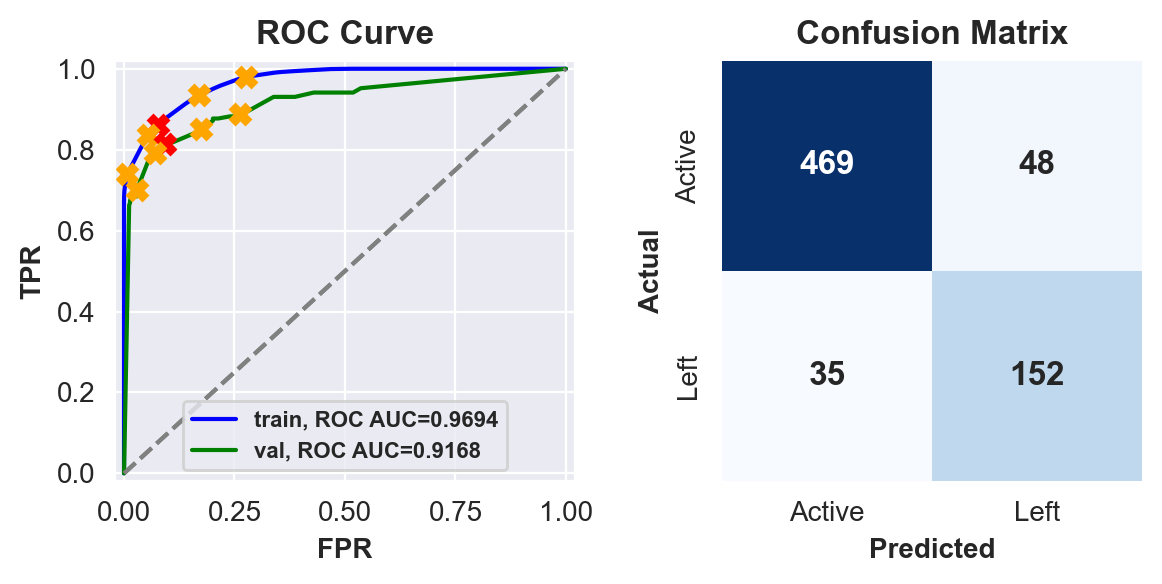

,train,validation
ROC AUC,0.9694,0.9168
Accuracy,0.8928,0.8821


In [99]:
# Evaluate the model and save the result
result[model_name] = evaluate_model(best_model[model_name], X_train_up, y_train_up, X_val, y_val)

The decision tree model has a validation ROC AUC score of 0.9235 which is better than the logistic regression model. The improvement is due to the better prediction result on the majority class. Nevertheless, the model has a mild overfitting issue.

In [100]:
# Create the model saving path
model_path = os.path.join(model_folder, f'{model_name}.pkl')

# Save the model
save_model(best_model[model_name], model_path, model_name)

The Decision Tree model has been successfully saved.


[Back to Contents](#back)

#### 7.1.4 LightGBM <a id='lgbm'></a>

The following hyperparameters will be tuned:

- `num_leaves`: The complexity of the model increases with the number of leaves. Therefore, a high number of leaves may lead to overfitting.
- `max_depth`: The maximum depth of a single tree.
- `n_estimators`: The total number of trees. This number should be large enough to reduce the variance and prevent model from being overfitting. However, it will be computational expensive for a large number of trees. 
- `learning_rate`: This parameter decides the step size of the gradient descent in the optimisaton process. A small value may not find the optimised value if the number of trees is not large enough. A large value speeds up the training speed but may overshoot the optimised value.
- `reg_alpha`: The L1 regularisation which penalise large weights on the features and thus prevent overfitting. L1 regularisation encourages the sparsity in the features (the weight can be zero)
- `reg_lambda`: The L2 regularisation. This L2 regularisation is similar to the L1 regularisation but does not enforce sparsity.

In [101]:
# Set up for the modeling process
model_name = 'LightGBM'
opt_model = LGBMClassifier

# Create the optuna study objective
def objective(trial):
    # Define the search space
    hyperparameters = {       
        'num_leaves': trial.suggest_int('num_leaves', 4, 256),
        'max_depth': trial.suggest_int('max_depth', 5, 500),     
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1e3, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1e3, log=True),        
        'verbose': trial.suggest_int('verbose', -1, -1)
    }
    
    # Train and evaluate the model
    model = opt_model(**hyperparameters)
    model.fit(X_train_up, y_train_up)
    val_roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

    return val_roc_auc

# Number of search to find the best model
n_trials = 100

In [102]:
%%time
# Search the best possible model
best_model[model_name], train_time[model_name] = optimise_model(
    opt_model, objective, X_train_up, y_train_up, X_val, y_val, n_trials, model_name
)

Optimising LightGBM... :   0%|          | 0/100 [00:00<?, ?it/s]

Best hyperparameters:


{'num_leaves': 12,
 'max_depth': 368,
 'n_estimators': 110,
 'learning_rate': 0.4504928825873537,
 'reg_alpha': 1.4637271359056245,
 'reg_lambda': 1.1836742970355332,
 'verbose': -1}


CPU times: total: 2min
Wall time: 30.3 s


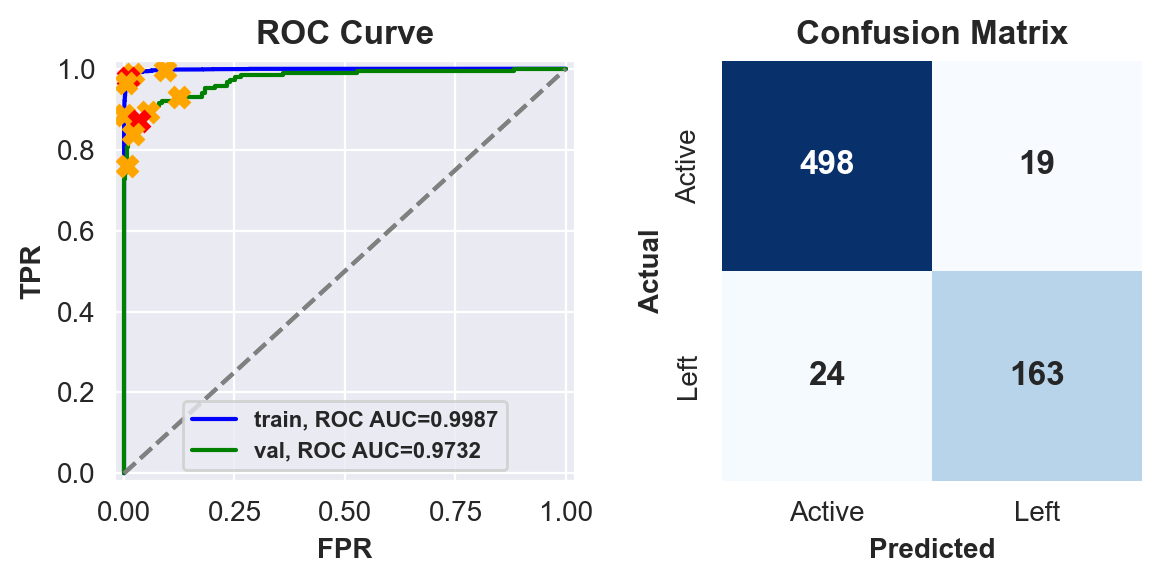

,train,validation
ROC AUC,0.9987,0.9732
Accuracy,0.9843,0.9389


In [103]:
# Evaluate the model and save the result
result[model_name] = evaluate_model(best_model[model_name], X_train_up, y_train_up, X_val, y_val)

The LightGBM model has a superb validation ROC AUC score of 0.9732, which make it the best model at the moment. The performance on both the majority and minority classes are also improved. Let's see if the CatBoost and XGBoost models can beat it.

In [104]:
# Create the model saving path
model_path = os.path.join(model_folder, f'{model_name}.pkl')

# Save the model
save_model(best_model[model_name], model_path, model_name)

The LightGBM model has been successfully saved.


[Back to Contents](#back)

#### 7.1.5 CatBoost <a id='cat'></a>

The following hyperparameters will be tuned:

- `max_depth`
- `n_estimators`
- `learning_rate`
- `reg_lambda`

*Note: CatBoost does not support number of leaves and L1 regularisation hyperparameters.*

In [105]:
# Set up for the modeling process
model_name = 'CatBoost'
opt_model = CatBoostClassifier

# Create the optuna study objective
def objective(trial):
    # Define the search space
    hyperparameters = {       
        'max_depth': trial.suggest_int('max_depth', 3, 16),     
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e0, log=True),        
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1e3, log=True),        
        'verbose': trial.suggest_categorical('verbose', [False])
    }
    
    # Train and evaluate the model
    model = opt_model(**hyperparameters)
    model.fit(X_train_up, y_train_up)
    val_roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

    return val_roc_auc

# Number of search to find the best model
n_trials = 100

In [106]:
%%time
# Search the best possible model
best_model[model_name], train_time[model_name] = optimise_model(
    opt_model, objective, X_train_up, y_train_up, X_val, y_val, n_trials, model_name
)

Optimising CatBoost... :   0%|          | 0/100 [00:00<?, ?it/s]

Best hyperparameters:


{'max_depth': 3,
 'n_estimators': 295,
 'learning_rate': 0.45671488869248533,
 'reg_lambda': 0.28827128612933073,
 'verbose': False}


CPU times: total: 48min 21s
Wall time: 9min 8s


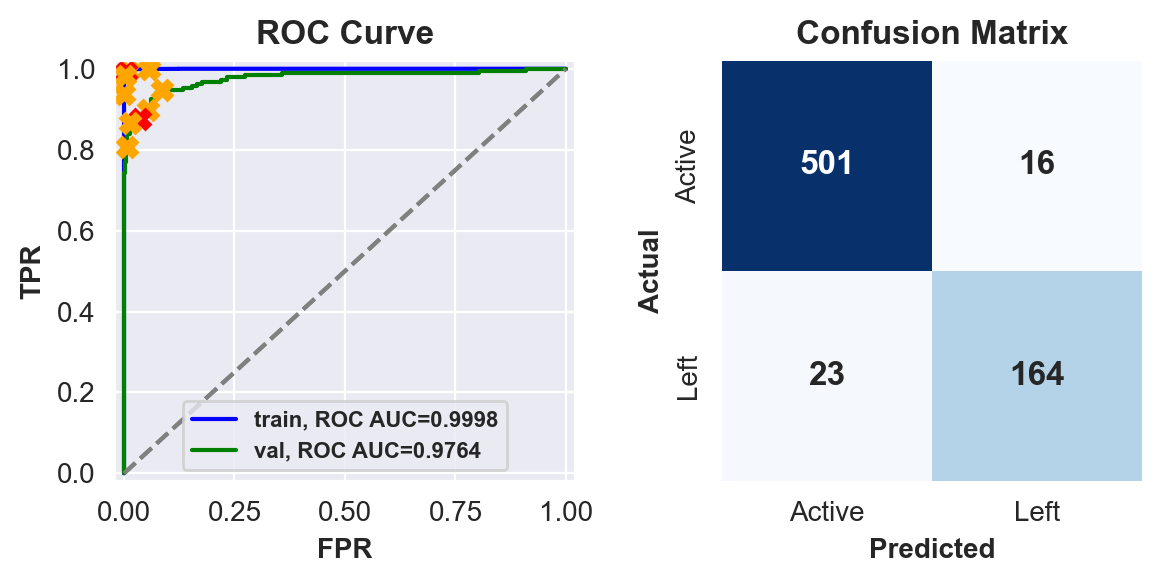

,train,validation
ROC AUC,0.9998,0.9764
Accuracy,0.9935,0.9446


In [107]:
# Evaluate the model and save the result
result[model_name] = evaluate_model(best_model[model_name], X_train_up, y_train_up, X_val, y_val)

The CatBoost model achieves an even better validation ROC AUC score of 0.9764 compared to the LightGBM model.

In [108]:
# Create the model saving path
model_path = os.path.join(model_folder, f'{model_name}.pkl')

# Save the model
save_model(best_model[model_name], model_path, model_name)

The CatBoost model has been successfully saved.


[Back to Contents](#back)

#### 7.1.6 XGBoost <a id='xgb'></a>

The following hyperparameters will be tuned:

- `num_leaves`
- `max_depth`
- `n_estimators`
- `learning_rate`
- `reg_alpha`
- `reg_lambda`

In [109]:
# Set up for the modeling process
model_name = 'XGBoost'
opt_model = XGBClassifier

# Create the optuna study objective
def objective(trial):
    # Define the search space
    hyperparameters = {       
        'num_leaves': trial.suggest_int('num_leaves', 4, 256),
        'max_depth': trial.suggest_int('max_depth', 5, 500),     
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1e3, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1e3, log=True),        
        'verbose': trial.suggest_int('verbose', -1, -1)
    }
    
    # Train and evaluate the model
    model = opt_model(**hyperparameters)
    model.fit(X_train_up, y_train_up)
    val_roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

    return val_roc_auc

# Number of search to find the best model
n_trials = 100

In [110]:
%%time
# Search the best possible model
best_model[model_name], train_time[model_name] = optimise_model(
    opt_model, objective, X_train_up, y_train_up, X_val, y_val, n_trials, model_name
)

Optimising XGBoost... :   0%|          | 0/100 [00:00<?, ?it/s]

Best hyperparameters:


{'num_leaves': 140,
 'max_depth': 8,
 'n_estimators': 287,
 'learning_rate': 0.31852063525572527,
 'reg_alpha': 0.00282970072963123,
 'reg_lambda': 0.004255285377656108,
 'verbose': -1}


CPU times: total: 3min 46s
Wall time: 57.1 s


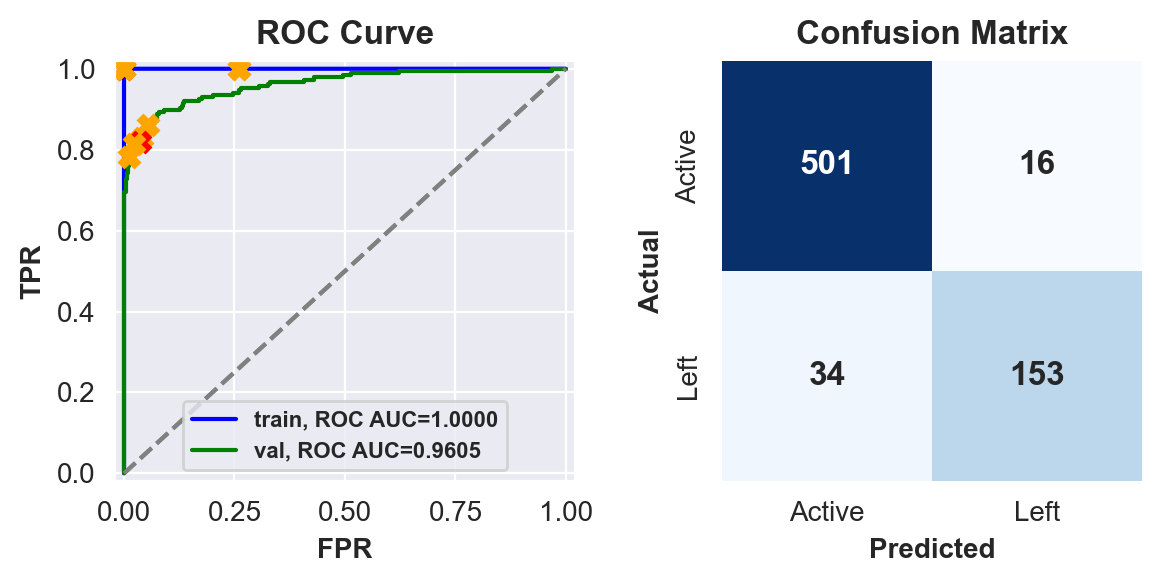

,train,validation
ROC AUC,1.0,0.9605
Accuracy,1.0,0.9290


In [111]:
# Evaluate the model and save the result
result[model_name] = evaluate_model(best_model[model_name], X_train_up, y_train_up, X_val, y_val)

The XGBoost model has a validation ROC AUC score of 0.9681 which is the lowest among the three gradient boosting ensembles.

In [112]:
# Create the model saving path
model_path = os.path.join(model_folder, f'{model_name}.pkl')

# Save the model
save_model(best_model[model_name], model_path, model_name)

The XGBoost model has been successfully saved.


[Back to Contents](#back)

## 8. Model Evaluation <a id='model_evaluation'></a>

### 8.1 Final Model Selection <a id='final_model'></a>

Let's evaluate the six models to choose the final model.

In [113]:
# Merge the recorded result
result_df = pd.merge(
    pd.DataFrame(result).transpose(),
    pd.DataFrame([train_time]).transpose().rename(columns={0: 'training_time (ms)'}),
    left_index = True,
    right_index = True
).sort_values('val_roc_auc', ascending=False)

# Have a look at the result
result_df

,train_roc_auc,val_roc_auc,train_acc,val_acc,prediction_time (ms),training_time (ms)
CatBoost,0.9998,0.9764,0.9935,0.9446,1.00,854.71
LightGBM,0.9987,0.9732,0.9843,0.9389,1.99,66.82
XGBoost,1.0000,0.9605,1.0000,0.9290,5.98,371.01
Decision Tree,0.9694,0.9168,0.8928,0.8821,1.00,34.90
Logistic Regression,0.9043,0.8898,0.8137,0.7940,1.37,72.14
Constant,0.5000,0.5000,0.7345,0.7344,0.00,1.99


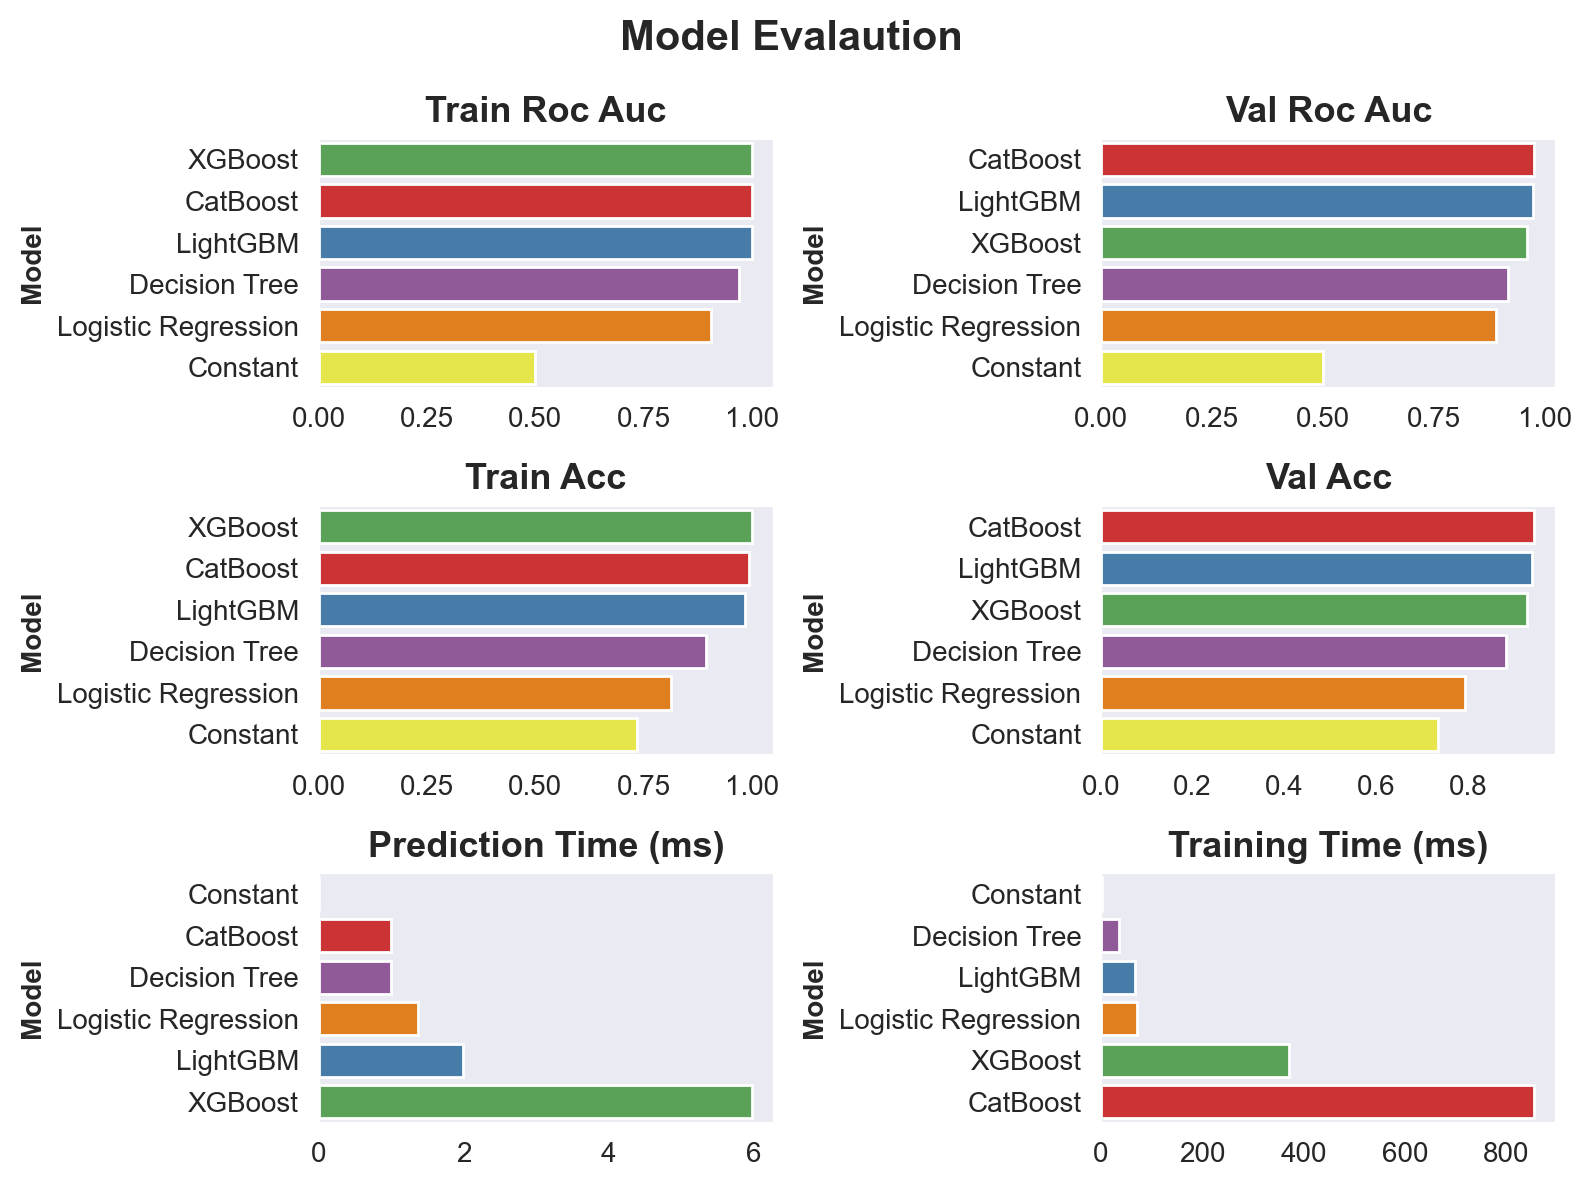

In [114]:
# Plot bar charts to visualise the result
nrows, ncols = 3, 2
sns.set_style('dark')

fig, axs = plt.subplots(nrows, ncols, figsize=(8, 6))

fig.suptitle('Model Evalaution', fontsize=15, fontweight='bold')

# Assign a specific color for each models
colors = sns.color_palette('Set1')
model_colors = {}
for i, model in enumerate(result_df.index):
    color = colors[i % len(colors)]
    model_colors[model] = color

# Plot the bar charts
for i in range(nrows):
    for j in range(ncols):
        col = result_df.columns[i*ncols + j]
        if 'time' in col:
            col_data = result_df[col].sort_values()
        else:
            col_data = result_df[col].sort_values(ascending=False)

        ax = axs[i][j]
        sns.barplot(y=col_data.index, x=col_data.values, hue=col_data.index, palette=model_colors, ax=ax)
        title = ' '.join([word.capitalize() for word in col.split('_')])
        ax.set_title(title, fontsize=13, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('Model', fontweight='bold')

plt.tight_layout()
plt.show()

**Model Evaluation**

- All the models outperform the baseline constant model. Notably, the gradient boosting ensembles demonstrate superior performance compared to other models.
- Each model shows mild to moderate overfitting, especially the XGBoost and decision tree models.
- In terms of time, the XGBoost model requires more time for predictions than the other models, while the CatBoost model has the longest training duration.
- **The CatBoost model which has the highest validation ROC AUC score of 0.9764 is chosen as the final model. Additonally, the model also has the fastest prediction time among the three gradient boosting ensembles.**

[Back to Contents](#back)

### 8.2 Feature Importances <a id='feature_importances'></a>

Let's have a look at the feature importances in predicting the customer churn by the CatBoost model.

In [115]:
# Find the feature importances returned by the CatBoost model
feature_importance = pd.DataFrame({
    'feature': best_model['CatBoost'].feature_names_,
    'feature_importance': best_model['CatBoost'].feature_importances_
}).sort_values('feature_importance', ascending=False)

# Show the top 10 features
feature_importance.head(10)

,feature,feature_importance
3,subscribed_days,43.135762
4,subscribed_years,31.532392
1,total_charges,11.100803
0,monthly_charges,5.698314
15,internet_service_Fiber optic,2.114078
26,streaming_tv_not_subscribed,1.004433
7,type_Two year,0.795823
5,total_internet_services,0.441417
6,type_One year,0.441076
10,payment_method_Electronic check,0.400360


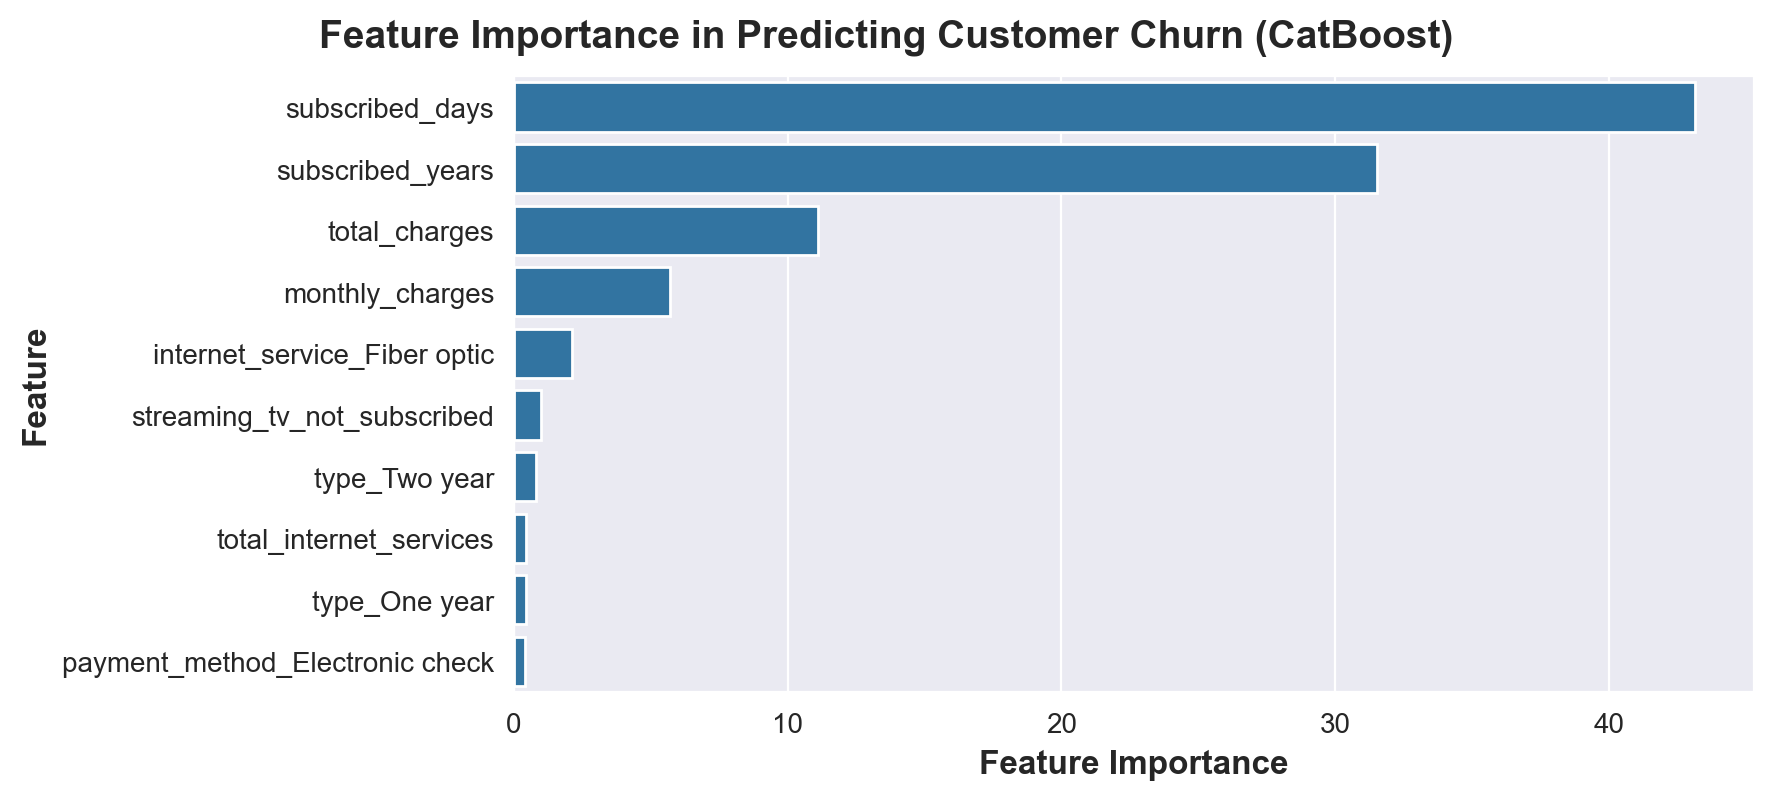

In [116]:
# Plot a bar chart to visualise the top 10 features
sns.set_style('darkgrid')
plt.figure(figsize=(8, 4))

sns.barplot(data=feature_importance[:10], y='feature', x='feature_importance')
plt.title('Feature Importance in Predicting Customer Churn (CatBoost)', x=0.3, y=1.02, fontsize=14, fontweight='bold')
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')

plt.show()

The features `subscribed_days`, `subscribed_years`, `total_charges`, `monthly_charges` and `internet_service_Fiber optic` are five of the most important features to predict customer churn.

[Back to Contents](#back)

### 8.3 Evaluation of the Final Model on the Test Set <a id='test_evaluation'></a>

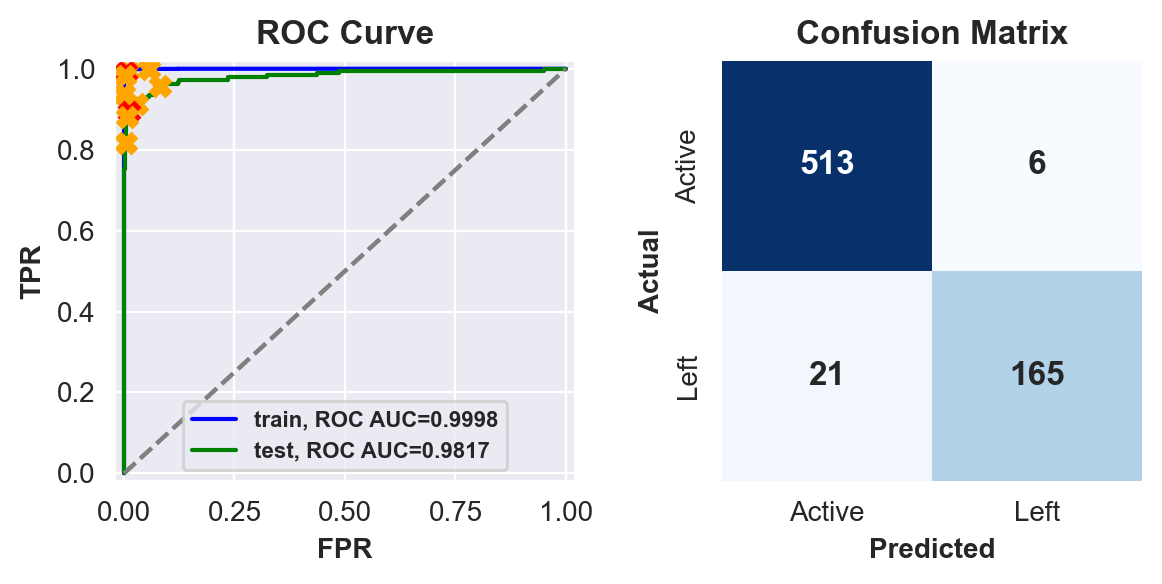

,train,test
ROC AUC,0.9998,0.9817
Accuracy,0.9935,0.9617


In [117]:
# Evaluate the final model on the test set
evaluate_model(best_model['CatBoost'], X_train_up, y_train_up, X_test, y_test, test_set=True)

The CatBoost model maintains a consistent performance on the test set with a ROC AUC score of 0.9817 and an accuracy of 0.9617. However, the model shows a less satisfactory results in predicting the minority class `Left`. To verify this, we will examine the classification report.

In [118]:
# Print the classification report of CatBoost
print(classification_report(y_test, best_model['CatBoost'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       519
           1       0.96      0.89      0.92       186

    accuracy                           0.96       705
   macro avg       0.96      0.94      0.95       705
weighted avg       0.96      0.96      0.96       705



By comparing the recall and f1-score, it is obvious that the CatBoost model exhibits a slightly inferior performance in predicting the minority class.

In [119]:
# Sanity check the lgbm model with the linear regression model
base_roc_auc = roc_auc_score(y_test, best_model['Constant'].predict(X_test))
cat_roc_auc = roc_auc_score(y_test, best_model['CatBoost'].predict(X_test))

print('The CatBoost model outperforms the linear regression model on test set by ', end='')
print(f'{(cat_roc_auc / base_roc_auc) - 1:.2%}')

The CatBoost model outperforms the linear regression model on test set by 87.55%


[Back to Contents](#back)

## 9. General Conclusion <a id='general_conclusion'></a>

**Data Exploration**

The marketing team of the telecom operator Interconnect has provided us four datasets - `contract`, `personal`, `internet` and `service`. These datasets recorded 7043 customers and the relevant information. After investigating on the datasets, the following issues have been detected:

- All the column names are in camal cases.
- The `EndDate` has some values of `No` which are not date values
- The `TotalCharges` column has non-numeric values ` ` which indicate that the customers are new clients.
- The data types of `BeginDate`, `EndDate` and `TotalCharges` are incorrect.

**Data Preprocessing**

In this stage, the the datasets have been manipulated and cleaned in the following ways.

- Merged the four datasets based on the common column `customerID` and filled the missing values in `InternetService` and `MultipleLines` with `not_subcribed`.
- Converted the column names into snake case.
- Created the target variable `churn` from the `end_date` column.
- Replaced the `No` values in `end_date` with `None` and the ` ` values in `total_charges` with `0`.
- Converted the data types of `begin_date` and `end_date` into `datetime`, the data type of `total_charges` into `float`.
- Added the `monthly_payment` to the `total_charges` since the current records does not reflect the current month charge.

Besides that, four additional features have been created in the feature engineering process.

- `subscribed_days` and `subscribed_years`: Created from the `begin_date` and `end_date`.
- `subscribed_service`: Type of subscribed service (landline communication service, internet service or both)
- `total_internet_services`: By calculating the number of additional internet services from `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, and `streaming_movies`.

**Exploratory Data Analysis (EDA)**

After analysing the customer characteristics and behaviours, the following conclusion have been made.

1. The customers who have left tend to have a higher monthly payment. The customers with a monthly payment of `70-110` have a higher churn rate of 36.79% compared to the other customers.
2. Most of the customers (68.65%) subscribed for both the landline communication and internet services.
3. Although there was a great increament in the number of acquired customers since September of 2019, the number of leaving customers was doubled than the joining customers.
4. Among the internet service users, fiber optic is the main choice but the churn rate from this service is also significantly higher, compared to the DSL users.
5. The customer using only the landline communication service have a slightly shorter subscription duration.
6. The churn rate from the customers with month-to-month contracts is at least four times the churn rates from the other two groups.
7. While the churn rate is higher among the users who subcribed for both services, the customers are less likely to leave when they subscribe more additional internet services.
8. The churn rate among the customers using electronic check and paperless billing to make the payment is twice the churn rate among the customers using other payment methods.
9. The elder people are more likely to leave the telecom operator. On the other hand, the customers with partner or dependents are less likely to terminate the services.
10. The longer the subscription duration, the lower the chance of leaving the telecom operator.
11. The target classes are imbalanced, with 73.46% of active customers and 26.54% of customers who have left.

**Modeling**

Before training the models, the categorical features was encoded and feature scaling was performed on the numerical features. Since the dataset is imbalanced with target classes, the minority class in the training set was upsampled. A total of six models including constant model, logistic regression, decision tree, LightGBM, CatBoost and XGBoost have been developed. Specific hyperparameters were tuned for each model.

**Model Evaluation**

All the models outperform the baseline constant model and achieve a minimum of ROC AUC score of 0.85 as required. **The CatBoost model which has the highest validation ROC AUC score of 0.9764 is chosen as the final model. Additonally, the model also has the fastest prediction time among the three gradient boosting ensembles.** For the CatBoost model, the top five features in predicting customer churn are `subscribed_days`, `subscribed_years`, `total_charges`, `monthly_charges` and `internet_service_Fiber optic`. Nevertheless, the CatBoost model has a slightly inferior performance in predicting the leaving customers.

[Back to Contents](#back)

## 10. Model Deployment <a id='deployment'></a>

In [120]:
# Save the necessary items for model deployment
# Save the standard scaler
pickle.dump(sc, open('scaler.pkl', 'wb'))

# Save the feature names
pickle.dump(X_train.columns, open('feature_columns.pkl', 'wb'))

[Back to Contents](#back)

## 11. Recommendations <a id='recommendations'></a>

For future works,

1. Since we have found out that the elder people are more likely to churn, we could collect the customer age data and have an investigation if the churn rate is related to age. This could possibly improve the model performance.
2. Collect some other demographic data such as education level, occupation, living area, etc. to have a further analysis.
3. To address the performance issue in predicitng the minority class (the leaving customers), we may try the following techniques:
    - Apply the hyperparameter `class weight` in the classifier to penalise the model for misclassifying the minority class.
    - Use more advanced resampling techniques like adasyn, SMOTETomek, etc.
4. Experiment with other models or combine the prediction of several models with a stacking ensemble.

[Back to Contents](#back)